<a href="https://colab.research.google.com/github/lab-midas/ismrm-moco-workshop/blob/master/HandsOn_ISMRM_MoCo_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-on Motion Estimation and Correction**
In this hands-on of the [ISMRM Workshop on Motion Detection and Correction 2022](https://www.ismrm.org/workshops/2022/Motion/), we aim to convey the principles of motion artifacts, their appearance in the MR image, means of estimating motion (conventional and deep learning) and correcting for the induced motion artifacts.

## Provided material
Two datasets (brain and heart) are distributed with this hands-on tutorial:
- `brain_large.npz` (GIT LFS): multi-coil 3D T1w brain MR image; matrix size = 256 x 216 x 65 x 7 (X x Y x Slices x Channels)
- `brain_slice.npz`: single central slice of `brain_large.npz`; matrix size = 256 x 216 x 7 (X x Y x Channels)
- `heart_large.npz` (GIT LFS): multi-coil, multi-slice 2D cardiac CINE MR image; matrix size = 176 x 132 x 12 x 25 x 10 (X x Y x Slices x Cardiac Phases x Channels)

**Attention:** The following codes are only defined for 2D processing. If you plan to use them for a 3D dataset, you would first need to extend some of the functions below.

# 0. Prerequisites


## Installation

### Python packages

In [1]:
# install dependencies
! pip install --upgrade pip
! pip install simpleitk git+https://github.com/khammernik/medutils.git python-pysap scikit-image # imjoy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/khammernik/medutils.git to /tmp/pip-req-build-z9dfsu28
  Running command git clone --filter=blob:none --quiet https://github.com/khammernik/medutils.git /tmp/pip-req-build-z9dfsu28
  Resolved https://github.com/khammernik/medutils.git to commit ed549868e9c0e4b5eb053b75058a7e0af9ec3ae2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Download ESPIRiT code for coil sensitivity map estimation
!git clone https://github.com/mikgroup/espirit-python.git
!cp /content/espirit-python/espirit.py .

Cloning into 'espirit-python'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), done.


### GPUNUFFT

In [5]:
%%bash
# setup gpunufft
git clone --branch cuda_streams https://github.com/khammernik/gpuNUFFT.git
export CUDA_ROOT_DIR=/usr/local/cuda
#!export CUDA_SDK_ROOT_DIR=/usr/local/cuda-samples
export LDFLAGS=-L/usr/local/cuda/lib64
mkdir -p gpuNUFFT/CUDA/build
cd gpuNUFFT/CUDA/build
cmake .. -DGEN_MEX_FILES=OFF
make

-- Setting DEBUG Option to false
-- setting NVCC FLAGS to: -arch=sm_50;-gencode;arch=compute_50,code=sm_50;-gencode=arch=compute_52,code=sm_52;-gencode=arch=compute_52,code=compute_52;-gencode=arch=compute_60,code=sm_60;-gencode=arch=compute_61,code=sm_61;-gencode=arch=compute_61,code=compute_61;-gencode=arch=compute_70,code=sm_70;-gencode=arch=compute_75,code=sm_75
-- creating lib with name: gpuNUFFT_ATM_f
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /content/gpuNUFFT/CUDA/build
Consolidate compiler generated dependencies of target gpuNUFFT_ATM_f
[ 11%] Linking CXX shared library ../../../../bin/libgpuNUFFT_ATM_f.so
[100%] Built target gpuNUFFT_ATM_f


fatal: destination path 'gpuNUFFT' already exists and is not an empty directory.
add CUDA 8 flags: Current version: 11.1
add CUDA 9 flags: Current version: 11.1
add CUDA 10 flags: Current version: 11.1
------start creating libraries-------
Atomic GPU GpuNUFFT Library


In [6]:
%%bash
apt install libnfft3-dev
pip install gpuNUFFT pynfft2

Reading package lists...
Building dependency tree...
Reading state information...
libnfft3-dev is already the newest version (3.3.2-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Optox

In [7]:
# Ensure only tensorflow with GPU support is installed
! pip uninstall --yes tensorflow
! pip install tensorflow-gpu

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation:

In [11]:
%%bash
# setup optox
git clone https://github.com/midas-tum/optox.git
export GPUNUFFT_ROOT_DIR=/content/gpuNUFFT
export LDFLAGS=-L/usr/local/cuda/lib64
cd /content/optox
pip install -r requirements.txt
mkdir -p /content/optox/build
cd /content/optox/build
cmake .. -DWITH_PYTHON=ON -DWITH_PYTORCH=ON -DWITH_TENSORFLOW=ON
make install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
-- CUDA_TOOLKIT_ROOT_DIR: /usr/local/cuda
-- CUDA_SDK_ROOT_DIR: /usr/local/cuda/samples/common/inc
-- CMAKE_BUILD_TYPE: Release
-- BUILD_SHARED_LIBS: ON
-- CMAKE_C_FLAGS= 
-- CMAKE_CXX_FLAGS = -std=c++14 -fPIC -fmax-errors=3 -fpermissive -ggdb -Wall -Wc++11-compat -O2 -ffast-math -DNDEBUG
-- CMAKE_CXX_FLAGS_RELEASE = -O3 -DNDEBUG
-- CUDA_NVCC_FLAGS= -arch=sm_50;-gencode;arch=compute_50,code=sm_50;-gencode=arch=compute_52,code=sm_52;-gencode=arch=compute_52,code=compute_52;-gencode=arch=compute_60,code=sm_60;-gencode=arch=compute_61,code=sm_61;-gencode=arch=compute_61,code=compute_61;-gencode=arch=compute_70,code=sm_70;-gencode=arch=compute_75,code=sm_75;-gencode=arch=compute_86,code=sm_86;-expt-extended-lambda;-ftemplate-backtrace-limit=2;-lineinfo;-std=c++14;-Xcompiler=-fPIC;-O2;-keep;-src-in-ptx;-DNDEBUG;-Xptxas=-warn-

fatal: destination path 'optox' already exists and is not an empty directory.
STATUS,cuda sdk not set
add CUDA 8 flags: Current version: 11.1
add CUDA 9 flags: Current version: 11.1
add CUDA 10 flags: Current version: 11.1
add CUDA 11 flags: Current version: 11.1
COMPILER FLAGS:
Doxygen needs to be installed to generate the doxygen documentation
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc warni

In [9]:
# set some environment variables in Google Colab that are not automatically handled
import os
import tensorflow as tf

os.environ["Tensorflow_INCLUDE_DIRS"] = str(tf.sysconfig.get_include())
os.environ["Tensorflow_LIB_DIRS"] = str(tf.sysconfig.get_lib())
os.environ["Tensorflow_LIB"] = str(tf.sysconfig.get_link_flags()[1])
os.environ["Tensorflow_FLAGS"] = str(tf.sysconfig.get_compile_flags()[1])

In [12]:
%%bash
pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.2.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.8
boke

### MERLIN

In [13]:
%%bash
# setup MERLIN
git clone https://github.com/midas-tum/merlin.git
cd merlin/python
python ./setup.py build
cd ..
pip install ./python
pip install ./pytorch
pip install ./tensorflow

running build
running build_py
creating build
creating build/lib
creating build/lib/merlinpy
copying ./merlinpy/experiment.py -> build/lib/merlinpy
copying ./merlinpy/utils.py -> build/lib/merlinpy
copying ./merlinpy/__init__.py -> build/lib/merlinpy
copying ./merlinpy/fft.py -> build/lib/merlinpy
creating build/lib/merlinpy/fastmri
copying ./merlinpy/fastmri/data.py -> build/lib/merlinpy/fastmri
copying ./merlinpy/fastmri/utils.py -> build/lib/merlinpy/fastmri
copying ./merlinpy/fastmri/__init__.py -> build/lib/merlinpy/fastmri
creating build/lib/merlinpy/wandb
copying ./merlinpy/wandb/utils.py -> build/lib/merlinpy/wandb
copying ./merlinpy/wandb/__init__.py -> build/lib/merlinpy/wandb
creating build/lib/merlinpy/recon
copying ./merlinpy/recon/iterativeSENSE.py -> build/lib/merlinpy/recon
copying ./merlinpy/recon/BART.py -> build/lib/merlinpy/recon
copying ./merlinpy/recon/__init__.py -> build/lib/merlinpy/recon
creating build/lib/merlinpy/losses
copying ./merlinpy/losses/__init__.py 

Cloning into 'merlin'...


In [ ]:
# inspect the available GPU hardware
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Mon Aug  8 08:51:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### BART

We install dependencies for BART. Make sure that you have installed the requirements if you run locally:

In [ ]:
%%bash

[ $COLAB -ne 1 ] && echo "Skipp cell (not on Colab)" && exit 0

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Install additional dependencies for converting ISMRMRD files
apt-get install -y libismrmrd-dev libboost-all-dev libhdf5-serial-dev &> /dev/null



bash: line 2: [: -ne: unary operator expected


#### Clone and Compile BART

We clone BART into the current working directory of this notebook and delete any previous installation in this directory.

In [ ]:
%%bash

# Clone Bart
! [ -d bart ] && rm -r bart
! git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [ ]:
%%bash

cd bart

# Define compile options
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                NON_DETERMINISTIC=1
                ISMRMRD=1
                "

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local


#if [ $COLAB -eq "1" ];
#then
# set path to cuda for Colab
echo "CUDA_BASE=/usr/local/cuda" >> Makefiles/Makefile.local
echo "CUDA_LIB=lib64" >> Makefiles/Makefile.local
#fi


make &> /dev/null

#### Add BART to PATH variable

We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [ ]:
import os
import sys

os.environ['TOOLBOX_PATH']=os.getcwd()+"/bart/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

Check BART setup:

In [ ]:
%%bash

echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart//bart
# BART version: 
v0.7.00-539-ge0fe7c0


## Imports

In [7]:
import numpy as np
import medutils
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os 
import sys

BART toolbox not setup properly or not available


## Data loading

In [8]:
# Load the numpy

datapath = '/content/drive/MyDrive/ISMRM_MoCo_Data/brain_slice.npz'  # brain_slice 
data = np.load(datapath)
img = data['arr_0']

nX, nY, nCha = np.shape(img)

In [9]:
# Loading the data
# from Drive as a placeholder for now -> replace with git pull
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper functions

In [10]:
import numpy as np

def zpad(x, s, mode='constant'):
    # x: input data
    # s: desired size
    # mode: padding mode (constant, ...)
    if type(s) is not np.ndarray:
        s = np.asarray(s, dtype='f')

    if type(x) is not np.ndarray:
        x = np.asarray(x, dtype='f')

    m = np.asarray(np.shape(x), dtype='f')
    if len(m) < len(s):
        m = [m, np.ones(1, len(s) - len(m))]

    if np.sum(m == s) == len(m):
        return x

    idx = list()
    diff = list()
    for n in range(np.size(s)):

        if np.remainder(s[n], 2) == 0:
            idx.append(np.arange(np.floor(s[n] / 2) + 1 + np.ceil(-m[n] / 2) - 1, np.floor(s[n] / 2) + np.ceil(m[n] / 2)))
        else:
            idx.append(np.arange(np.floor(s[n] / 2) + np.ceil(-m[n] / 2) - 1, np.floor(s[n] / 2) + np.ceil(m[n] / 2) - 1))

        if s[n] != m[n]:
            diff.append( ( int(np.abs(idx[n][0])), int(np.abs(s[n]-1 - idx[n][-1])) ) )
        else:
            diff.append( (0, 0) )

    padval = tuple(i for i in diff)
    return np.pad(x, padval, mode=mode)

In [11]:
import numpy as np
import scipy.io as sio
# import optopy.gpunufft as op
import pysap
from mri.operators import NonCartesianFFT

def get_kpos(n_FE, n_spokes, RadProfOrder, start_angle):
    # n_FE = number of points along each radial spoke
    # n_spokes = number of radial spokes
    # RadProfOrder = string with either "GC" for golden angle or "GC_23deg" for tiny golden angle
    # start_angle = if you want to rotate the trajectory by some amount you can change the start_angle.
    #
    # Ouput is kpos containing k-space positions along x and y normalized from -0.5 to +0.5.

    # K - space values along each radial spoke
    # delta_kr = 1 / size(Data, 1);
    delta_kr = 1 / n_FE
    rad_pos = np.arange(-0.5, 0.5, delta_kr) # :0.5 - delta_kr

    # Angles of different radial spokes
    if RadProfOrder == 'golden':  # golden angle
        RadialAngles = np.arange(0, n_spokes)*(np.pi/180)*(180*0.618034)
        isalternated = 0

    elif RadProfOrder == 'tinygolden':  # Andreia Gaspar 02 / 08 / 2016 tiny golden angle
        RadialAngles = np.arange(0, n_spokes)*(np.pi/180)*(180*0.1312674636)
        isalternated = 0

    else:  # linear order
        RadialAngles = np.arange(0, n_spokes)*(np.pi/n_spokes)
        # Flag indicating that each even radial line is sampled from +k_max to - k_max and each odd line is acquired from -k_max to + k_max
        isalternated = 1

    RadialAngles = RadialAngles + start_angle * np.pi / 180

    # Kpos has to be the same size as the FE, PE and SE dimension of MR.Data

    kpos = CalcTraj_2d_radial(rad_pos, RadialAngles, isalternated)

    return np.transpose(kpos, (2, 1, 0))   # tranpose to: _, num_spokes, num_readout

def CalcTraj_2d_radial(rad_pos, rad_angles, isalternated):
    # Calculate k - space trajectory for a 2D radial acquisition

    # rad_pos: K - space points along radial spokes
    # rad_angles: Angle values for each of the radial lines
    # isalternated: Flag indicating that each even radial line is sampled from +k_max to - k_max and each odd line is acquired from -k_max to + k_max

    rad_pos = np.asarray(rad_pos, dtype=np.float32)
    rad_angles = np.asarray(rad_angles, dtype=np.float32)
    kpos = np.zeros((np.shape(rad_pos)[0], np.shape(rad_angles)[0], 2))

    if isalternated:
        # Radius from -k_max to + k_max
        kpos[:, :, :][:, 0:-1:2, :][:, :, 0] = rad_pos[:, np.newaxis] * np.sin(rad_angles[0:-1:2])[:, np.newaxis].transpose()
        kpos[:, :, :][:, 0:-1:2, :][:, :, 1] = rad_pos[:, np.newaxis] * np.cos(rad_angles[0:-1:2])[:, np.newaxis].transpose()

        # Radius from +k_max to - k_max
        kpos[:, :, :][:, 1:-1:2, :][:, :, 0] = -rad_pos[:, np.newaxis] * np.sin(rad_angles[1:-1:2])[:, np.newaxis].transpose()
        kpos[:, :, :][:, 1:-1:2, :][:, :, 1] = -rad_pos[:, np.newaxis] * np.cos(rad_angles[1:-1:2])[:, np.newaxis].transpose()

    else:
        kpos[:,:,1] = rad_pos[:, np.newaxis] * np.sin(rad_angles)[:, np.newaxis].transpose()
        kpos[:,:,0] = rad_pos[:, np.newaxis] * np.cos(rad_angles)[:, np.newaxis].transpose()

    return kpos

def generateRadialTrajectory(Nread, Nspokes=1, kmax=0.5):
    """ Generate a radial trajectory
    :param Nread: number of readout steps
    :param Nspokes: number of spokes
    :param kmax: maximum k-space sampling frequency
    :return: complex-valued trajectory
    """
    tmp_trajectory = np.linspace(-1, 1, num=Nread, endpoint=False) * kmax
    trajectory = np.zeros((2, Nread, Nspokes))
    for n in range(Nspokes):
        phi = (np.mod(Nspokes,2) + 1) * np.pi * n / Nspokes
        kx = np.cos(phi)*tmp_trajectory
        ky = np.sin(phi)*tmp_trajectory
        trajectory[0,:,n] = kx
        trajectory[1,:,n] = ky
    return trajectory
    #return trajectory[0] + 1j*trajectory[1]

def calc_radial_dcf(kpos, lens):
    """ This is suboptimal... Room for (a lot of) improvement. """
    dcf = []
    num_phases, _, num_spokes, num_readout = kpos.shape
    #num_readout, num_spokes, _ = kpos.shape
    #num_phases = 1
    for idx_bin in range(num_phases):
        dcf_idx = compute_radial_dcf(kpos[idx_bin])
        # print(np.max(dcf_idx), lens[idx_bin])
        dcf_idx = dcf_idx * num_readout * np.pi  # dirty hack... / (lens[idx_bin]) * 2 * np.pi # * num_readout #* 2.5 # correct with nyu trick?
        dcf.append(dcf_idx)
    dcf = np.ascontiguousarray(dcf)

    return dcf  # / np.max(dcf)

def compute_radial_dcf(Kpos):
    angles = np.degrees(np.arctan2(Kpos[1,...,0], Kpos[0,...,0])) + 180   # previously [1,...] [0,....]
    dcf = np.linspace(-0.5, 0.5, Kpos.shape[-1])
    dcf = np.tile(np.abs(dcf), [Kpos.shape[1], 1])

    idx = np.argsort(angles)
    sorted_angles = angles[idx]

    last_angle = sorted_angles[-1]
    first_angle = sorted_angles[0]

    angle_n = np.insert(sorted_angles[:-1], 0, last_angle - 360)
    angle_p = np.append(sorted_angles[1:], first_angle + 360)

    delta_p = np.abs(angle_p - sorted_angles)
    delta_n = np.abs(angle_n - sorted_angles)

    sorted_diff = 0.5 * np.radians(delta_p + delta_n)
    # dcf = np.maximum(dcf, 1e-9)
    dcf[idx] *= 0.5 * sorted_diff[:, np.newaxis] / np.pi

    return dcf.reshape((1, *dcf.shape))

def subsample_radial(img_cart, smaps=None, acc=1, cphases=[0]):
    # return radial subsampled image

    # zero-pad to quadratic FOV
    maxsize = np.amax(np.shape(img_cart)[0:2])
    img_cart = zpad(img_cart, (maxsize, maxsize, np.shape(img_cart)[2], np.shape(img_cart)[3])).astype(np.complex64)

    nyquist_spokes = np.round(np.pi / 2 * maxsize)

    if acc > 1:
        n_spokes = int(np.round(nyquist_spokes / acc))
    else:
        n_spokes = int(nyquist_spokes)

    golden_angle = 180*0.618034
    if len(np.shape(img_cart) == 4):
      img_cart = img_cart[:, :, :, np.newaxis, :]
    
    nRO, _, nSlices, n_phases_img, ncoils = np.shape(img_cart)  
    n_phases = len(cphases)
    if np.any(np.asarray(cphases) > n_phases_img):
        raise ValueError

    img = np.transpose(img_cart, (3, 4, 2, 0, 1)).copy().view()  # phase must be first to be c-contiguous

    startangle = 0
    img_rad = []
    if smaps is None:
      csm = np.ones((1, maxsize, maxsize))
    for ipha in cphases:  #range(n_phases):
        kpos = get_kpos(maxsize, n_spokes, 'golden', startangle)
        #kpos = generateRadialTrajectory(int(maxsize), int(n_spokes))
        #kpos_idx = np.transpose(kpos_idx,(0,2,1))

        #kpos_idx = kpos_idx[np.newaxis, :, :, :]  # phases x 2 x nSpokes x nRO -> required input of dcf
        #kpos.append(kpos_idx)

        dcf = compute_radial_dcf(kpos)
        dcf = dcf * nRO * np.pi

        kpos = np.tile(kpos.reshape(1, -1, maxsize * n_spokes), (nSlices, 1, 1))
        dcf = np.tile(dcf.reshape(1, 1, maxsize * n_spokes) / np.max(dcf), (nSlices, 1, 1))

        #nufft = op.GpuNufft(img_dim=maxsize, osf=1, kernel_width=3, sector_width=5)
        #nufft.setDcf(dcf.astype(np.float32))  # nBatch x 1 x nRO * nSpokes
        #nufft.setTraj(kpos.astype(np.float32))  # nBatch x 2 x nRO * nSpokes
        #nufft.setCsm(csm.astype(np.complex64))  # nCoils x nRO x nRO
        #out = nufft.adjoint(nufft.forward(img[ipha, ...].astype(np.complex64)))
        nufft = NonCartesianFFT(samples=kpos, shape=np.shape(img), n_coils=np.shape(csm)[0], density_comp=dcf, smaps=csm)
        out = nufft.op(img)
        img_rad.append(out)

        startangle += golden_angle

    img_rad = np.transpose(np.ascontiguousarray(img_rad),(2,3,1,0))  # nRO x nRO x nSlices x cPhases
    return img_rad


In [12]:
import numpy as np


def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.arange(0,RY)/RY)
    col = col+RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.arange(0,YG)/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.arange(0,GC)/GC)
    col = col+GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.arange(CB)/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.arange(0,BM)/BM)
    col = col+BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.arange(MR)/MR)
    colorwheel[col:col+MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''
    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u)/np.pi

    fk = (a+1) / 2*(ncols-1)
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 0
    f = fk - k0

    for i in range(colorwheel.shape[1]):

        tmp = colorwheel[:,i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1-f)*col0 + f*col1

        idx = (rad <= 1)
        col[idx]  = 1 - rad[idx] * (1-col[idx])
        col[~idx] = col[~idx] * 0.75   # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2-i if convert_to_bgr else i
        flow_image[:, :, ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:,:,0]
    v = flow_uv[:,:,1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)

def plot_flow(flow_uv, title='',clip_flow=None, convert_to_bgr=False):
    flow_img = flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False)
    plt.imshow(flow_img)
    plt.title(title)
    plt.show()


In [13]:
import numpy as np
from skimage.transform import warp

def warp_2D(img, flow):
    flow = flow.astype('float32')
    height, width = np.shape(img)[0], np.shape(img)[1]
    posx, posy = np.mgrid[:height, :width]
    # flow=np.reshape(flow, [-1, 3])
    vx = flow[:, :, 0]  # to make it consistent as in matlab, ux in python is uy in matlab
    vy = flow[:, :, 1]
    coord_x = posx + vx
    coord_y = posy + vy
    coords = np.array([coord_x, coord_y])
    if img.dtype == np.complex128:
        img_real = np.real(img).astype('float32')
        img_imag = np.imag(img).astype('float32')
        warped_real = warp(img_real, coords, order=1)
        warped_imag = warp(img_imag, coords, order=1)
        warped = warped_real + 1j*warped_imag
    else:
        img = img.astype('float32')
        warped = warp(img, coords, order=1)  # order=1 for bi-linear

    return warped

In [14]:
def rss(coil_img):
  # root sum-of-squares coil combination
  return np.sqrt(np.sum(np.abs(coil_img)**2, -1))

def plot(img, flow=None, permorder=(2, 0, 1), title=''):
  # img        to be plotted image
  #            2D: single 2D image
  #            3D: third dimension is plotted side-by-side
  # flow       2D: [x, y, flowDir]
  #            3D: [x, y, slices, flowDir]
  #            flowDir being the x and y components of the flow
  # permorder  (rank > 2): move any dimension in the side-by-side plotting order
  # title      plotting title
    
  if np.iscomplex(img).any():
    img = np.abs(img)

  Nmax = 8
  M = int(np.ceil(np.shape(img)[-1] / Nmax))
  if M > 1:
    N = int(Nmax)
  else:
    N = int(np.shape(img)[-1])
  if flow is None:
    if len(np.shape(img)) == 3:
      medutils.visualization.imshow(medutils.visualization.plot_array(np.transpose(img, permorder), M=M, N=N), title=title, figsize=(40,20))
    else:
      medutils.visualization.imshow(img, title=title, figsize=(10,10))
  else:
    M 
    fig, axs = plt.subplots(M, N, figsize=(10, 10))
    nvec = 20  # Number of vectors to be displayed along each image dimension
    nl, nc, nd = img.shape
    step = max(nl//nvec, nc//nvec)

    y, x = np.mgrid[:nl:step, :nc:step]
    u, v = flow[..., 0, :], flow[..., 1, :]
    u_ = u[::step, ::step, :]
    v_ = v[::step, ::step, :]
    for idx, ax in enumerate(axs):
      ax.imshow(img[..., idx], cmap='gray')
      ax.quiver(x, y, u_[..., idx], v_[..., idx], color='y', units='dots',
           angles='xy', scale_units='xy', lw=3)
      ax.set_axis_off()
    plt.show()


%matplotlib inline

def plotcfl(files, title=None):
  import numpy as np
  from matplotlib import pyplot as plt
  import cfl
  import os

  from ipywidgets import interact, interactive, fixed, interact_manual
  import ipywidgets as widgets

  def update(Range=(0.,1.),Coil=0, Map=0, Slice=0, Batch=0):

    if(title==None):
      wtitle=[]
      for file in files:
        head, tail = os.path.split(file)
        wtitle.append(tail)
    else:
      wtitle=title
    
    data=cfl.readcfl(files[0])
    rat=data.shape[0]/data.shape[1]
    width=16
    
    ncols=len(files)
    nrows=1
    
    rat=rat
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=True, squeeze=False, figsize=(width, width*rat))

    for i in range(len(files)):
 
        data=cfl.readcfl(files[i])
        nshp = [1] * 16

        for k in range(len(data.shape)):
          nshp[k] = data.shape[k]

        idx=[0]*16
        idx[3]=min(Coil,nshp[3]-1)
        idx[4]=min(Map,nshp[4]-1)
        idx[13]=min(Slice,nshp[13]-1)
        idx[15]=min(Batch,nshp[15]-1)

        idx[0]=slice(None, None, -1)
        idx[1]=slice(None, None, None)

        dat=np.abs(data.reshape(nshp)[tuple(idx)])
        if 0 < np.max(dat):
          dat=dat/np.max(dat)

        axs.flatten()[i].imshow(dat,cmap="gray",vmin=Range[0], vmax=Range[1])
        axs.flatten()[i].set_title(wtitle[i])
    for ax in axs.flatten():
      ax.axis("off")
    
    plt.show()

  nshp = [1] * 16
  for file in files:
    data=cfl.readcfl(file)
    for i in range(len(data.shape)):
      nshp[i] = max(data.shape[i], nshp[i])
  
  interact(update,
           Range=widgets.FloatRangeSlider(value=[0.,1.], min=0, max=1.),
           Coil=widgets.IntSlider(min=0, max=nshp[3]-1, step=1, value=0),
           Map=widgets.IntSlider(min=0, max=nshp[4]-1, step=1, value=0),
           Slice=widgets.IntSlider(min=0, max=nshp[13]-1, step=1, value=0),
           Batch=widgets.IntSlider(min=0, max=nshp[15]-1, step=1, value=0))

In [15]:
%%bash
function imshow () {
    bart toimg -W $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}
export -f imshow

# version without automatic windowing
function imshow_nowin () {
    bart toimg $1 $1.png > /dev/null
    cat $1.png | display
    rm $1.png
}
export -f imshow_nowin

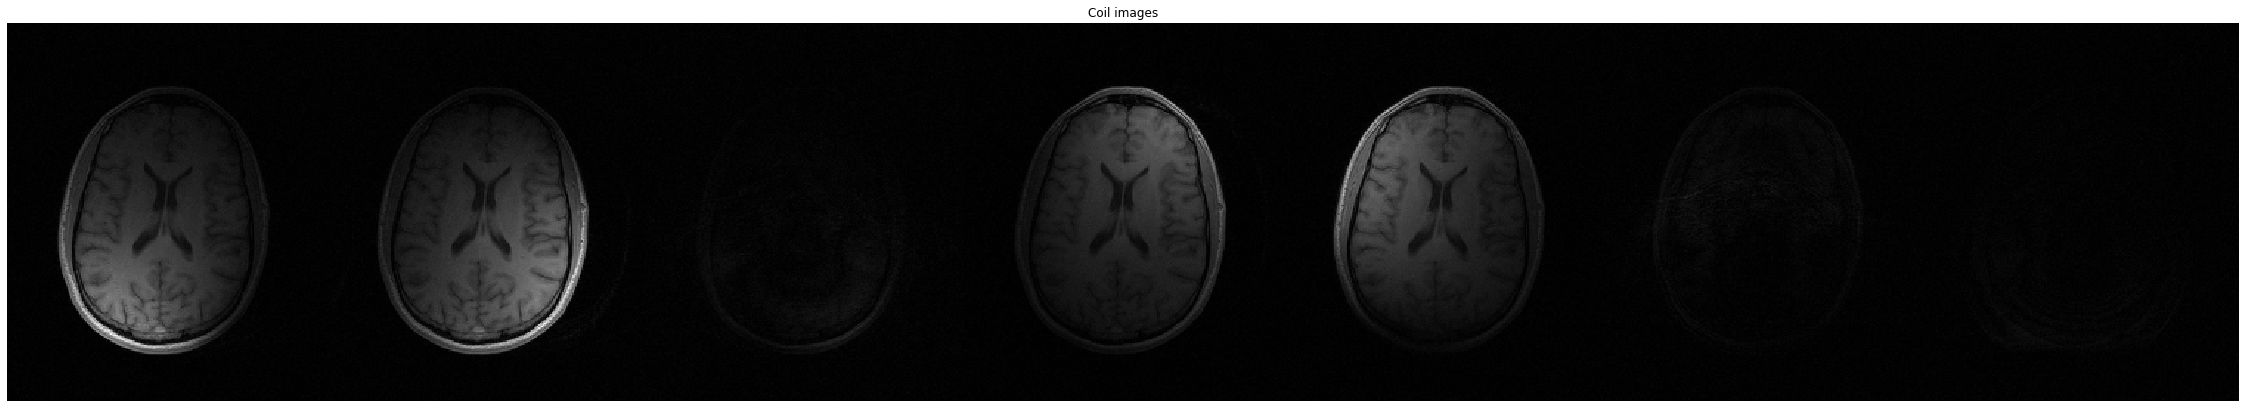

In [16]:
plot(img, title='Coil images')

# 1. Motion artifact appearance 
In this example, we will examine the impact of the motion artifacts on the image. Motion during an MR scan introduces blurring and aliasing (along the phase-encoding directions). Artifact appereance depends on the imaging trajectory: Cartesian and non-Cartesian. In the following we will first investigate the motion artifact appeareance on fully-sampled cases and then move towards undersampled/accelerated imaging trajectories.

## **Spatial description of motion**
For translational, rigid and affine motion exists a direct linear relationship between the motion-corrected/free k-space $\nu(k)$ and the motion-affected k-space $\nu'(k')$.

$$
\nu(k) = \nu'(k') \frac{\operatorname{exp}(2\pi i k'\cdot t)}{|\det (A)|}
$$
where $k'$ is the motion-affected k-space trajectory, $k$ is the motion-corrected/free k-space trajectory, $t=\lbrack t_x, t_y, t_z \rbrack^T$ is the translational component of the motion and $A$ is the affine motion matrix in 3D

$
\begin{align}
A = RGS = R_x R_y R_z G S = \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos \phi & -\sin \phi \\ 0 & \sin \phi & \cos \phi \end{bmatrix} \begin{bmatrix} \cos \theta & 0 & \sin \theta \\ 0 & 1 & 0 \\ -\sin \theta & 0 & \cos \theta \end{bmatrix} \begin{bmatrix} \cos \psi & -\sin \psi & 0 \\ \sin \psi & \cos \psi & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} 1 & G_{xy} & G_{xz} \\ 0 & 1 & G_{yz} \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} S_x & 0 & 0 \\ 0 & S_y & 0 \\ 0 & 0 & S_z \end{bmatrix}
\end{align}
$

consisting of the rotation matrices $R_x, R_y$ and $R_z$ (with angles $\lbrace \phi, \theta, \psi \rbrace$) along the respective axis $x, y$ and $z$, shearing matrix $G$ (with 3D shear parameters $\lbrace G_{xy}, G_{xz}, G_{yz} \rbrace$) and scaling matrix $S$ (with 3D scale factors $\lbrace S_x, S_y, S_z \rbrace$). 

In 2D, the affine motion matrix simplifies to

$
A=RGS = \begin{bmatrix} \cos \phi & \sin \phi \\-\sin \phi & \cos \phi \end{bmatrix} \begin{bmatrix} 1 & G_{xy} \\ 0 & 1 \end{bmatrix} \begin{bmatrix} S_x & 0 \\ 0 & S_y \end{bmatrix}
$

### Affine motion
The 3D affine transformation has 12 degrees of freedom consisting of 3D translations, rotations, shears and scaling. It maps the k-space point $k=\lbrack k_x, k_y, k_z \rbrack^T$ to the corrupted k-space point $k'=\lbrack k'_x, k'_y, k'_z \rbrack^T$ following $k'=A^{-T} k$ 

in k-space: $
\begin{bmatrix} k'_x \\ k'_y \\ k'_z \end{bmatrix} = R \begin{bmatrix} 1 & 0 & 0 \\ -G_{xy} & 1 & 0 \\ (G_{xy}G_{yz}-G_{xz}) & -G_{yz} & 1\end{bmatrix} \begin{bmatrix} S_x^{-1} & 0 & 0 \\ 0 & S_y^{-1} & 0 \\ 0 & 0 & S_z^{-1} \end{bmatrix} \begin{bmatrix} k_x \\ k_y \\ k_z \end{bmatrix}
$

or equivalently 

in image domain: $
\begin{bmatrix} x' \\ y' \\ z' \\ 1 \end{bmatrix} = \begin{bmatrix} & & & t_x \\ & R & & t_y \\ & & & t_z \\ 0 & 0 & 0 & 1 \end{bmatrix} GS \begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}
$

### Rigid motion
In case of rigid motion, we only have translation $t$ and rotation $R$, i.e. $G=S=I$, where $I$ is the identity matrix.

### Translational motion
For translational motion $t$, all other components are neglected, i.e. $R=G=S=I$.

### Elastic (non-rigid) motion 
For elastic motion, the image $\rho \in \mathbb{R}^N$ is deformed with a deformation field/motion model $u$ which is a vector field containing the motion vector at every voxel $u \in \mathbb{R}^{N \times D}$ for a $D$-dimensional registration. The deformed image is given as
$
\rho_d(x') = \rho(u(x))
$.

## **Temporal description of motion**
Motion represents a displacement over time and this can be addressed most directly by stating the spatial variation (i.e. the affine motion parameters) as a function of time. In practice, however, this belies the complexity of real physiologic motion, where limits on real-world acceleration, shear, etc. limit how displacement can practically vary over time. Moreover, some choice of discretization for the time domain is necessary.

### Regular motion
Many types of physiologic motion exhibit temporal regularity. Respiration has an inspiration and expiration phase; the heartbeat can be characterized by an approximately repeating waveform, identifiable by the QRS complex in the ECG. A key aspect of these types of motion is that while they are generally periodic, they do not necessarily have a fixed frequency through the duration of a scan — a subject may hold their breath; a heartbeat may skip. Therefore, these types of motion are often described as cyclic rather than periodic.

### Irregular motion
Irregular motions (e.g., head motion) are generally represented using a discretized time series of serial displacements.

In [17]:
def transform_img(img, p):
  # img      input image to be transformed
  # p        affine transformation parameters
  #          3D (rank(img) == 3): t_x, t_y, t_z, \phi [°], \theta [°], \psi [°], G_{xy}, G_{xz}, G_{yz}, S_x, S_y, S_z
  #          2D (rank(img) == 2): t_x, t_y, \phi [°], G_{xy}, S_x, S_y
  # return   transformed image

  dim = len(np.shape(img))
  p = np.asarray(p, dtype='float')
  if dim == 2:  # 2D
    trans = affine_translate(p[0:2], dim)
    rotate = affine_rotate(p[2], dim, tuple(np.asarray(np.shape(img))/2))
    shear = affine_shear(p[3], dim)
    scale = affine_scale(p[4:], dim)
  else:
    trans = affine_translate(p[0:4], dim)
    rotate = affine_rotate(p[4:7], dim, tuple(np.asarray(np.shape(img))/2))
    shear = affine_shear(p[7:6], dim)
    scale = affine_scale(p[6:], dim)

  affine = sitk.CompositeTransform([trans, rotate, shear, scale])
  return resample(img, affine)

def affine_translate(p_trans, dim=2):
    transform = sitk.AffineTransform(dim)
    transform.SetTranslation(p_trans)
    return transform

def affine_scale(p_scale, dim=2):
    transform = sitk.AffineTransform(dim)
    matrix = np.array(transform.GetMatrix()).reshape((dim,dim))
    matrix[0,0] = p_scale[0]
    matrix[1,1] = p_scale[1]
    if dim == 3:
      matrix[2,2] = p_scale[2]
    transform.SetMatrix(matrix.ravel())
    return transform

def affine_rotate(p_rotate, dim=2, center=(0, 0)):
    #parameters = np.array(transform.GetParameters())
    transform = sitk.AffineTransform(dim)
    transform.SetCenter(center)
    matrix = np.array(transform.GetMatrix()).reshape((dim,dim))
    if dim == 2:
      radians = -np.pi * np.asarray(p_rotate) / 180.
      rotation = np.array([[np.cos(radians), -np.sin(radians)],[np.sin(radians), np.cos(radians)]])
      new_matrix = np.dot(rotation, matrix)
    else:
      phi = np.pi * np.asarray(p_rotate)[0] / 180.
      theta = np.pi * np.asarray(p_rotate)[1] / 180.
      psi = np.pi * np.asarray(p_rotate)[2] / 180.
      Rx = [[1,       0,          0],
            [0,   np.cos(phi),  np.sin(phi)],
            [0,  -np.sin(phi),  np.cos(phi)]]

      Ry = [[np.cos(theta),   0,   np.sin(theta)],
            [0,       1,       0],
            [-np.sin(theta),   0,   np.cos(theta)]]

      Rz = [[np.cos(psi),   np.sin(psi),   0],
            [-np.sin(psi),   np.cos(psi),   0],
            [0,           0,       1]]
      new_matrix = np.linalg.multi_dot([Rx, Ry, Rz, matrix])
    transform.SetMatrix(new_matrix.ravel())
    return transform

def affine_shear(p_shear, dim=2):
    transform = sitk.AffineTransform(dim)
    matrix = np.array(transform.GetMatrix()).reshape((dim,dim))
    p_shear = np.asarray(p_shear)
    if dim == 2:
      matrix[0,1] = p_shear
    else:
      matrix[0,1] = p_shear[0]
      matrix[0,2] = p_shear[1]
      matrix[1,2] = p_shear[2]
    transform.SetMatrix(matrix.ravel())
    return transform

def resample(image, transform, interpolator=sitk.sitkLinear, default_value=0.0):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    if np.iscomplex(image).any():
      image = np.abs(image)
    imgin = sitk.GetImageFromArray(image)
    #interpolator = sitk.sitkCosineWindowedSinc
    #interpolator = sitk.sitkLinear
    imgres = sitk.GetArrayFromImage(sitk.Resample(image1=imgin, transform=transform, interpolator=interpolator, defaultPixelValue=default_value))
    if not np.shape(imgres) == np.shape(image):
      imgres = crop(imgres, np.shape(image))
    return imgres

# centered cropping
def crop(x, s):
    # x: input data
    # s: desired size
    if type(s) is not np.ndarray:
        s = np.asarray(s, dtype='f')

    if type(x) is not np.ndarray:
        x = np.asarray(x, dtype='f')

    m = np.asarray(np.shape(x), dtype='f')
    if len(m) < len(s):
        m = [m, np.ones(1, len(s) - len(m))]

    if np.sum(m == s) == len(m):
        return x

    idx = list()
    for n in range(np.size(s)):
        if np.remainder(s[n], 2) == 0:
            idx.append(list(np.arange(np.floor(m[n] / 2) + 1 + np.ceil(-s[n] / 2) - 1, np.floor(m[n] / 2) + np.ceil(s[n] / 2), dtype=np.int)))
        else:
            idx.append(list(np.arange(np.floor(m[n] / 2) + np.ceil(-s[n] / 2) - 1, np.floor(m[n] / 2) + np.ceil(s[n] / 2) - 1), dtype=np.int))

    index_arrays = np.ix_(*idx)
    return x[index_arrays]

## Motion in Cartesian imaging
We will first examine the impact of motion on Cartesian imaging. We can apply the motion in the image domain by the function: 

```
transform_img(img, p): 
# img      input image to be transformed
# p        affine transformation parameters
#          3D (rank(img) == 3): t_x, t_y, t_z, \phi, \theta, \psi, G_{xy}, G_{xz}, G_{yz}, S_x, S_y, S_z
#          2D (rank(img) == 2): t_x, t_y, \phi, G_{xy}, S_x, S_y
# return   transformed image
```
takes care of creating and applying the transformation to the input `img`. 



### Motion in fully-sampled imaging
**Task 1:** Apply a 2D translational motion with $t_x=10, t_y=5$ to the RSS coil-combined image (`img_rss = rss(img)`). 

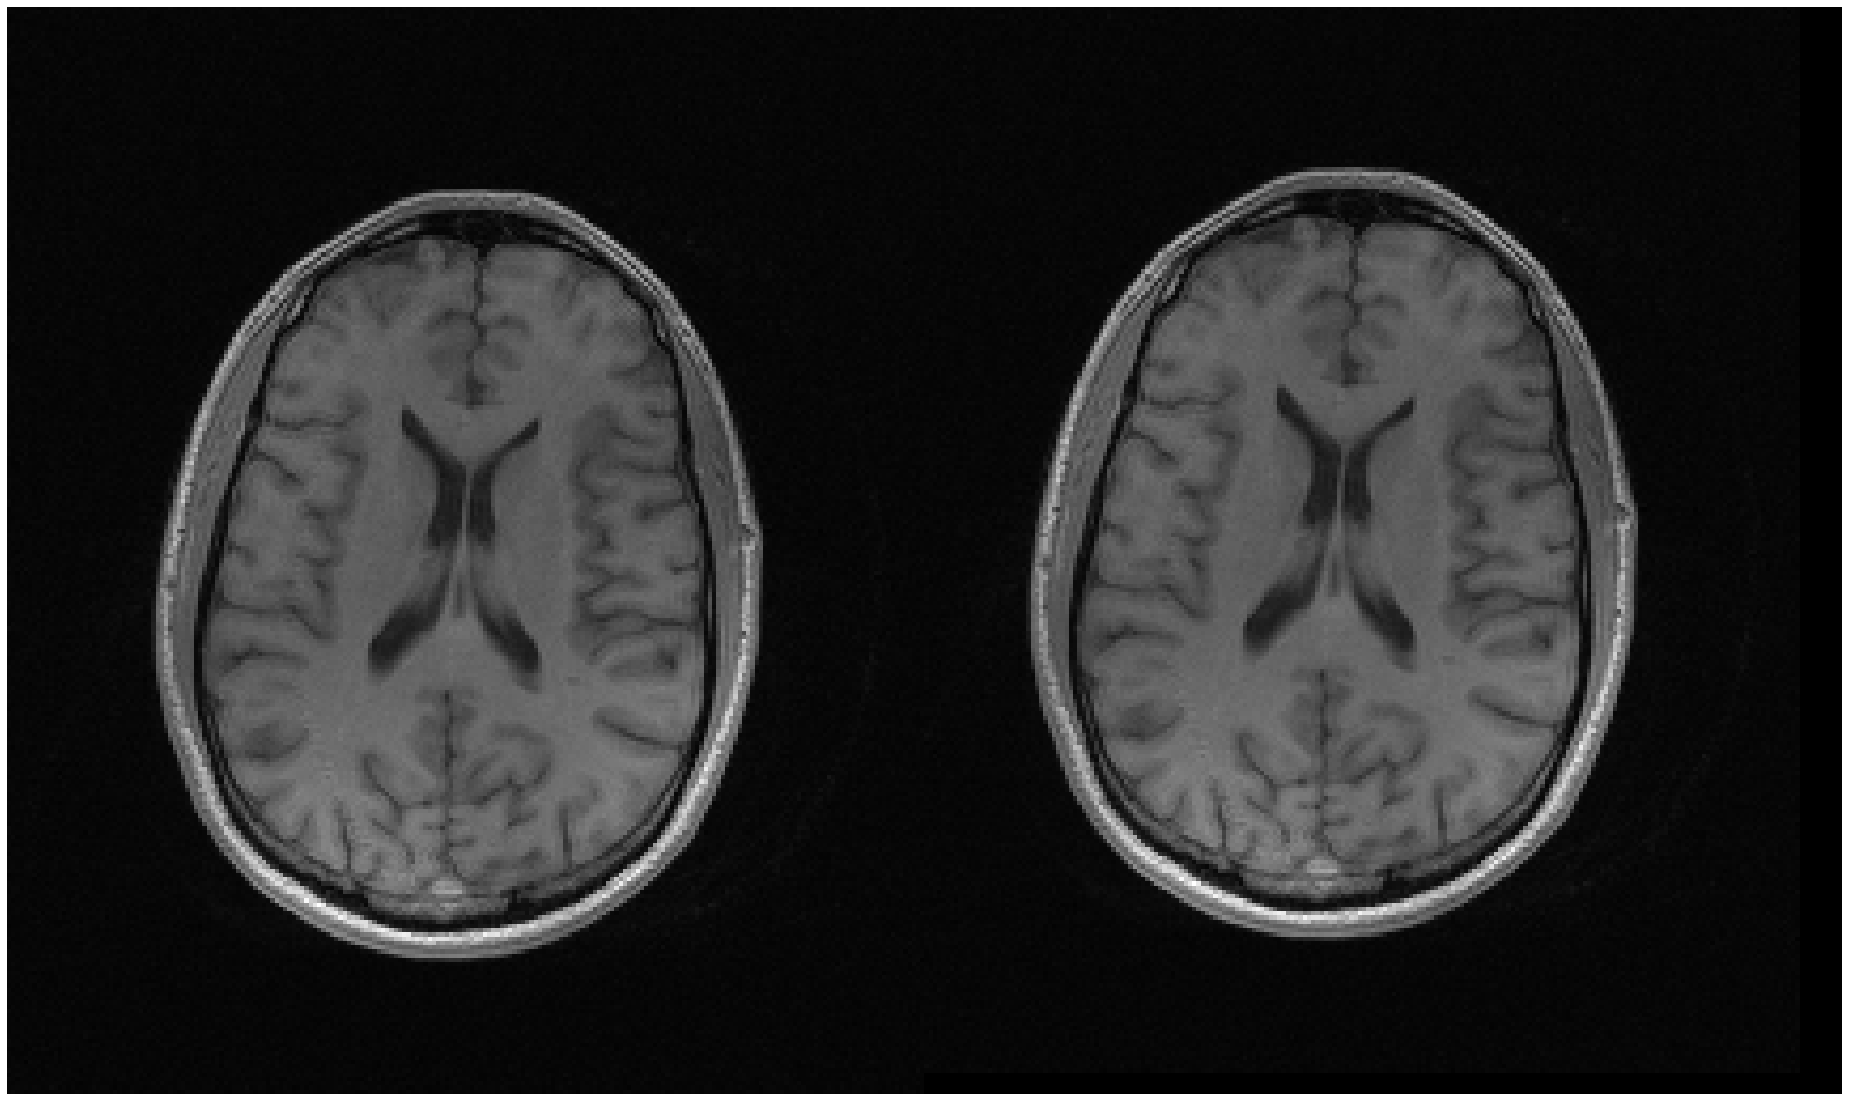

In [ ]:
img_rss = rss(img)
img_trans = transform_img(img_rss, [10, 5, 0, 0, 1, 1])
plot(np.stack([img_rss, img_trans], -1))

**Task 2:** Apply an in-plane rotation of $\phi=30^\circ$. 

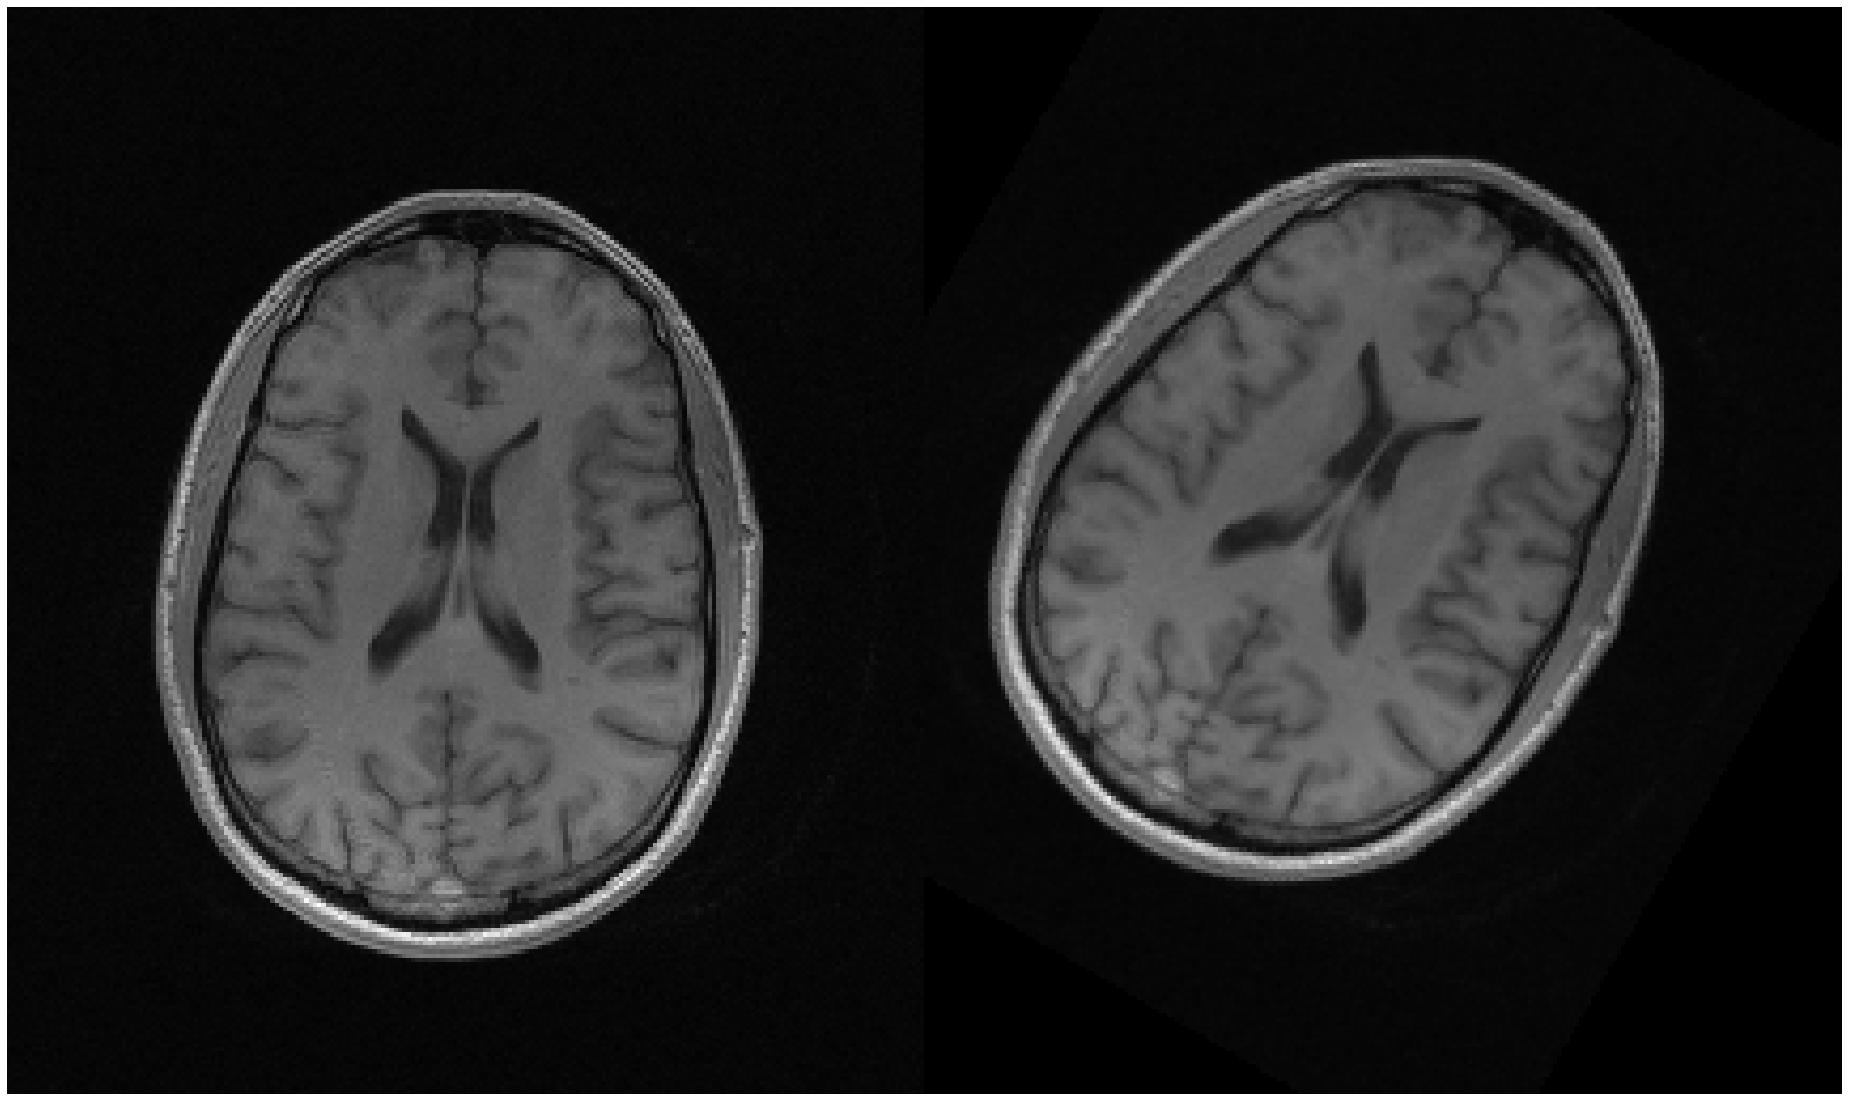

In [ ]:
img_rot = transform_img(img_rss, [0, 0, 30, 0, 1, 1])
plot(np.stack([img_rss, img_rot], -1))

**Task 3:** Try different combinations of translation, rotation, scalings and shearings. 

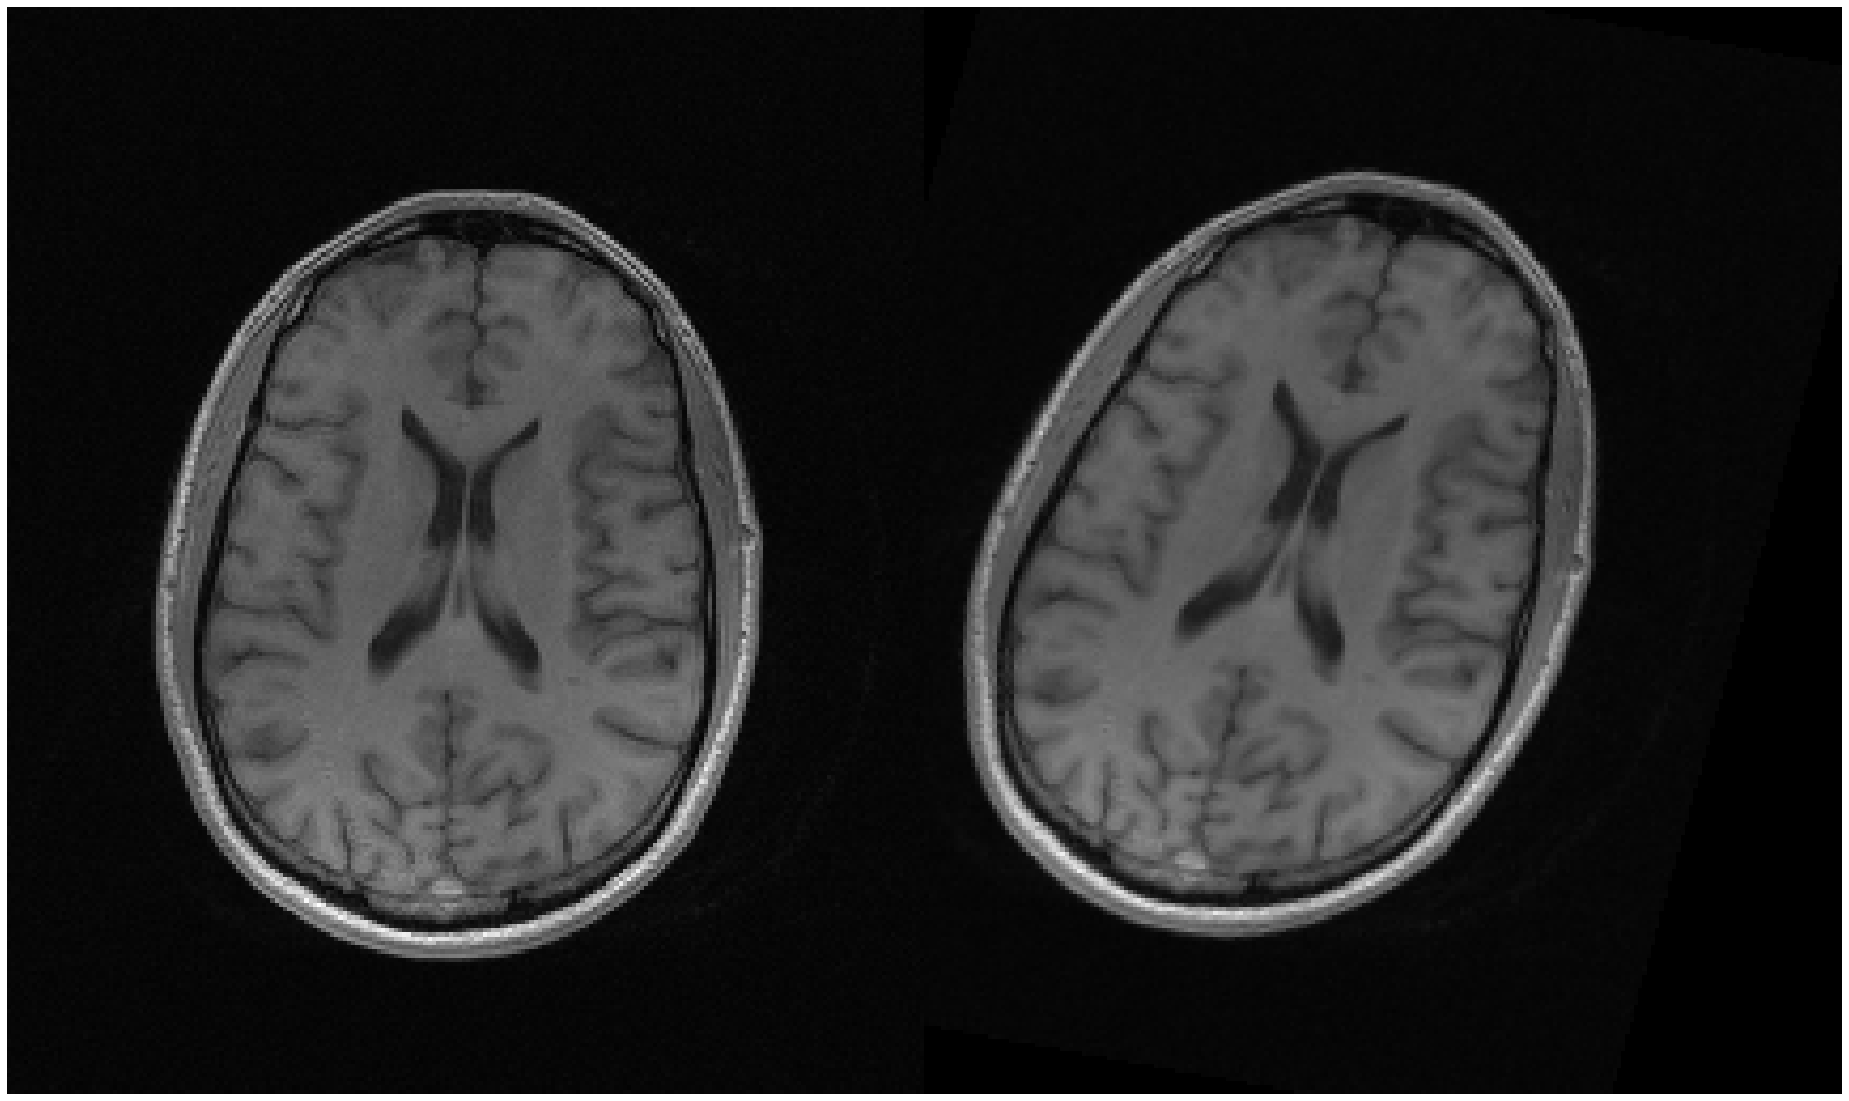

In [ ]:
img_affine = transform_img(img_rss, [4, 0, 10, 0.1, 1, 1])
plot(np.stack([img_rss, img_affine], -1))

**Task 4:** Write the equivalent affine operation of image transformation in k-space.

Let us now simulate a simple case of a motion-affected MR scan. Therefore, we will impact every $n$-th phase-encoding line with motion using the function `simulate_motion()`. In order to simulate it, we first need to set up the functions for a zero-filled reconstruction.

### Zero-filled reconstruction
In order to simulate motion and ultimately reconstruct an image, we need the multi-coil forward operator $A$ in `mriForwardOp(image, smaps, mask)` and adjoint operator $A^∗$ in `mriAdjointOp(kspace, smaps, mask)`, as well as an estimation of the coil sensitivities.

*Hint*: We perform a centered FFT with `ortho` normalization in order to provide adjoint operators. 
Suggested Readings:<br/>
Pruessmann et al. [SENSE: Sensitivity encoding for fast MRI](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291522-2594%28199911%2942%3A5%3C952%3A%3AAID-MRM16%3E3.0.CO%3B2-S) Magnetic Resonance in Medicine, 43(5):952-962, 1999.

#### Forward and adjoint operator

In [19]:
def mriAdjointOp(kspace, smaps, mask):
  return np.sum(ifft2c(kspace * mask)*np.conj(smaps), axis=-1)

def mriForwardOp(image, smaps, mask):
  return fft2c(smaps * image[:,:,np.newaxis]) * mask

def fft2c(image, axes=(0,1)):
  return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image, axes=axes), norm='ortho', axes=axes), axes=axes)

def ifft2c(kspace, axes=(0,1)):
  return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=axes), norm='ortho', axes=axes), axes=axes)

#### Coil sensitivity estimation
The coil sensitivity maps (`smaps`) are smooth maps that show us in which parts the individual coil elements are sensitive. We will need these information for our multi-coil MRI forward and adjoint operators. We use the [python implementation](https://github.com/mikgroup/espirit-python) for ESPIRiT [1,2] to estimate these coil sensitivity maps.

[1] Uecker et al. [ESPIRiT—an eigenvalue approach to autocalibrating parallel MRI: Where SENSE meets GRAPPA](https://onlinelibrary.wiley.com/doi/10.1002/mrm.24751). Magn Reson Med 71(3):990-1001, 2014.

[2] https://github.com/mikgroup/espirit-python

In [20]:
import espirit
kspace = fft2c(img)
kspace_espirit = kspace[:,:,np.newaxis,:]
smaps_espirit = espirit.espirit(kspace_espirit, 8, 20, 0.05, 0)

smaps = smaps_espirit[:,:,0,:,0]

Let us visualize the sensitivity maps

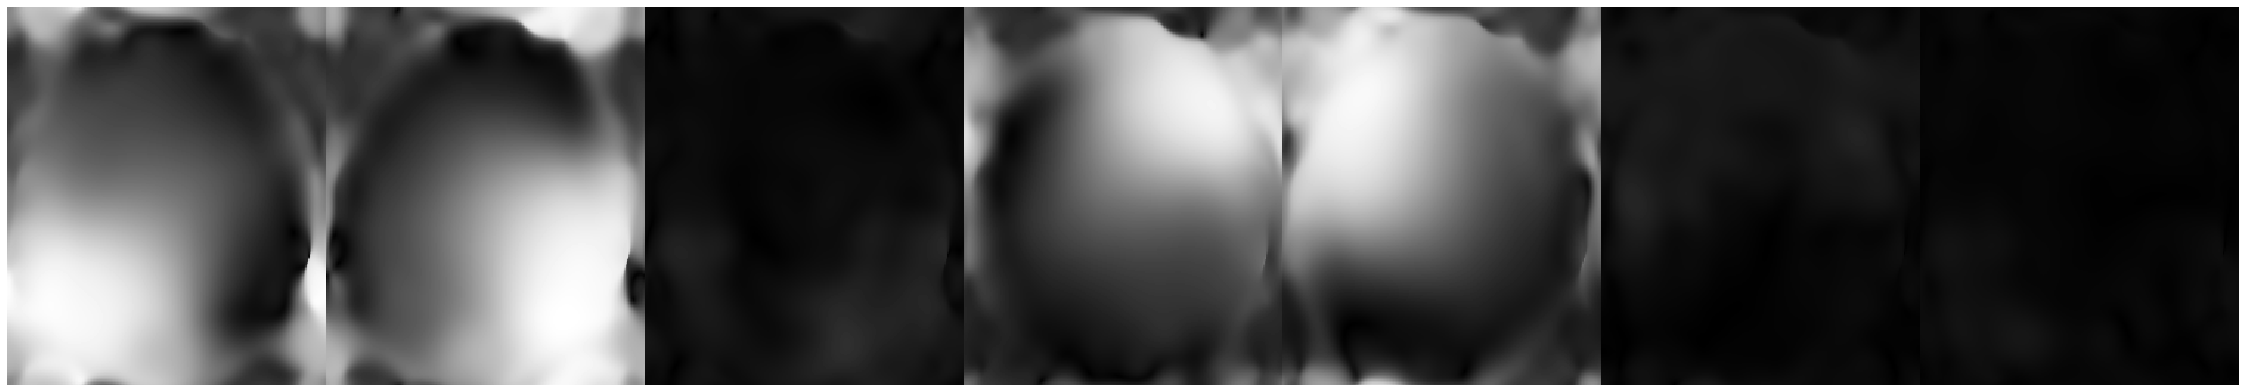

In [ ]:
plot(smaps)

Now, you should check if the adjoint operator is working as expected. The result should be a coil-combined image. Right now, there is no undersampling mask involved, i.e., it is set to all ones.

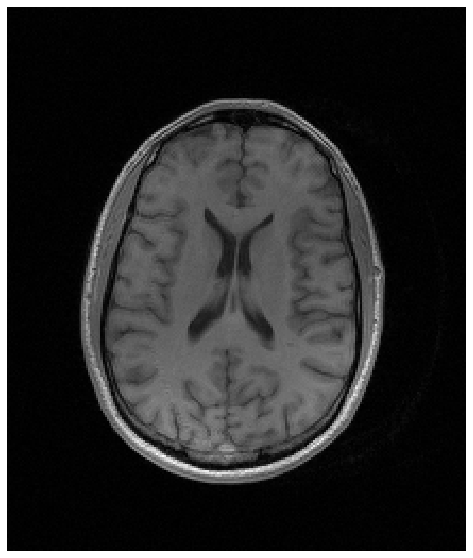

In [ ]:
sampling_mask_fs = np.ones_like(kspace)  # fully-sampled sampling mask
img_cc = mriAdjointOp(kspace, smaps, sampling_mask_fs)
plot(img_cc)

### Motion simulation
Now we can simulate motion in the acquired k-space. The temporal behaviour, i.e. when the motion happens can be described by motion signals, which we will look into more detail in the next section. First, we will simulate an abrupt and periodic motion. We will make use of the function `simulate_motion()`. 

In [ ]:
def simulate_motion(img_cc, smaps, mask, p):
  # img_cc      motion-free coil-combined image
  # smaps       coil sensitivity maps
  # mask        k-space sampling mask 
  # p           a) affine motion parameters (constant over time), 1x6
  #             b) affine motion course (time-dependent or time-constant), nPE x 6
  #             np.abs(p[:, :5]) > 0 = mask_motion; time points of phase-encoding steps 
  #             at which motion parameters > 0 are defined, i.e. motion is happening 

  kspace = mriForwardOp(img_cc, smaps, mask)
  p = np.asarray(p)
  tmp = np.unique(p, axis=0)
  if len(np.shape(p)) == 1:
    mask_motion = np.ones_like(kspace)
  else:
    mask_motion = np.abs(np.sum(p[:, :5], axis=1)) > 0
    mask_motion = np.tile(mask_motion[np.newaxis, :, np.newaxis], (np.shape(kspace)[0], 1, np.shape(kspace)[2]))

  if len(np.shape(p)) == 1 or np.shape(tmp[~np.all(tmp == 0, axis=1)])[0] == 1:  # constant motion over time    
    if len(np.shape(p)) != 1:
      p = np.squeeze(tmp[~np.all(tmp == 0, axis=1)])
    kspace_motion = mriForwardOp(transform_img(img_cc, p), smaps, mask)
    return kspace * (1-mask_motion) + kspace_motion * mask_motion, mask_motion
  else:  # time-dependent motion
    kspace_aff = np.zeros_like(kspace)
    for ky in np.arange(np.shape(img_cc)[1]):
      kspace_aff[:, ky, :] = mriForwardOp(transform_img(img_cc, p[ky, :]), smaps, mask)[:, ky, :]
    return kspace_aff, mask_motion
  

**Task 4:** Simulate a motion-affected image, such that every 4-th phase-encoding line (i.e. abrupt motion) is affected by a translational motion with $t_x=10, t_y=5$.

In [ ]:
p = [10, 5, 0, 0, 1, 1]
mask_motion = np.zeros(np.shape(sampling_mask_fs)[1])
mask_motion[::4] = 1
p = mask_motion[:, np.newaxis] * np.asarray(p)[np.newaxis, :]

kspace_motion, mask_motion = simulate_motion(img_cc, smaps, sampling_mask_fs, p)
img_motion = mriAdjointOp(kspace_motion, smaps, sampling_mask_fs)

#kspace = mriForwardOp(img_cc, smaps, np.ones_like(img_cc)[:,:,np.newaxis])
#kspace_aff = mriForwardOp(transform_img(img_cc, [10, 5, 0, 0, 1, 1]), smaps, np.ones_like(img_cc)[:,:,np.newaxis])
#kspace_motion, mask_motion = simulate_motion(kspace, kspace_aff, 4)
#img_motion = mriAdjointOp(kspace_motion, smaps, np.ones_like(kspace_motion))

Let us now visualize the motion-free and the motion-affected image side-by-side.

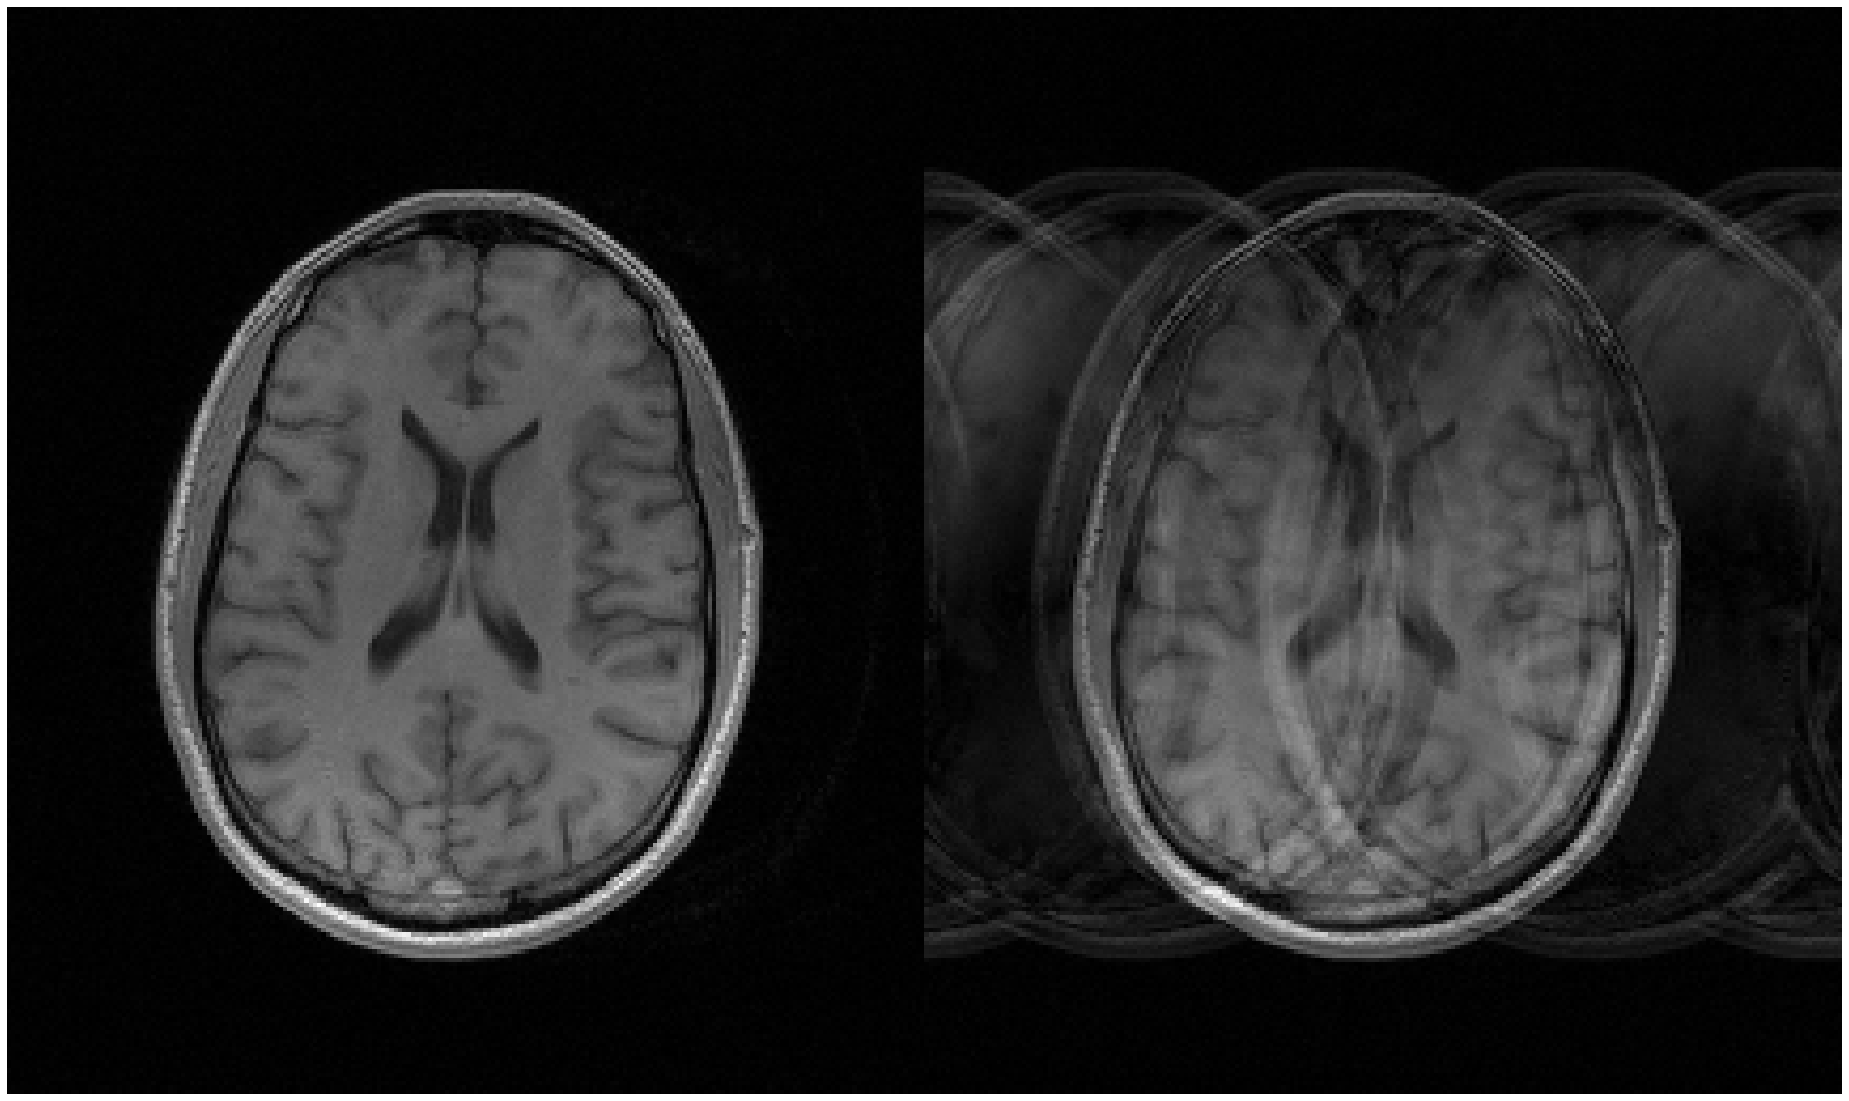

In [ ]:
plot(np.stack([img_cc, img_motion], -1))

### Temporal variation of motion
Motion represents a displacement over time and this can be addressed most directly by stating the spatial variation (i.e. the affine motion parameters) as a function of time. 

The simulated motion from the previous example affected every $n$-th phase-encoding line, i.e. every $n$ TRs (assuming one echo line per TR) an abrupt motion was happening. We can depict the temporal behaviour of the motion as a function of affine motion parameters over time with the help of `plot_motion_course()`. 

In [ ]:
def plot_motion_course(motion_course, TR=1):
  time = np.arange(np.shape(motion_course)[0]) * TR

  fig = plt.figure(figsize=(20, 10))
  ax1 = fig.add_subplot(111)
  ax2 = ax1.twiny()
  for icourse in np.arange(np.shape(motion_course)[1]):
    ax1.plot(time, motion_course[:,icourse])

  ax1.set_xlabel('time [s]')
  ax1.set_ylabel('affine motion parameter')

  ax1.set_xlim((time[0], time[-1]))
  ax2.set_xlim((time[0], time[-1]))
  ax2.set_xticks(np.linspace(0, np.shape(mask_motion)[1], 5))
  #ax2.set_xticklabels(np.arange(np.shape(mask_motion)[1]))
  ax2.set_xlabel(r"Phase-encoding lines")

  ax1.legend([r'$t_x$', r'$t_y$', r'$\phi$', r'$G_{xy}$', r'$S_x$', r'$S_y$'], loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.15))
  plt.show()

**Task 6:** Plot the affine motion parameters for the previous abrupt motion example as a function over time for a TR=5 ms and one echo (phase-encoding line) per TR.

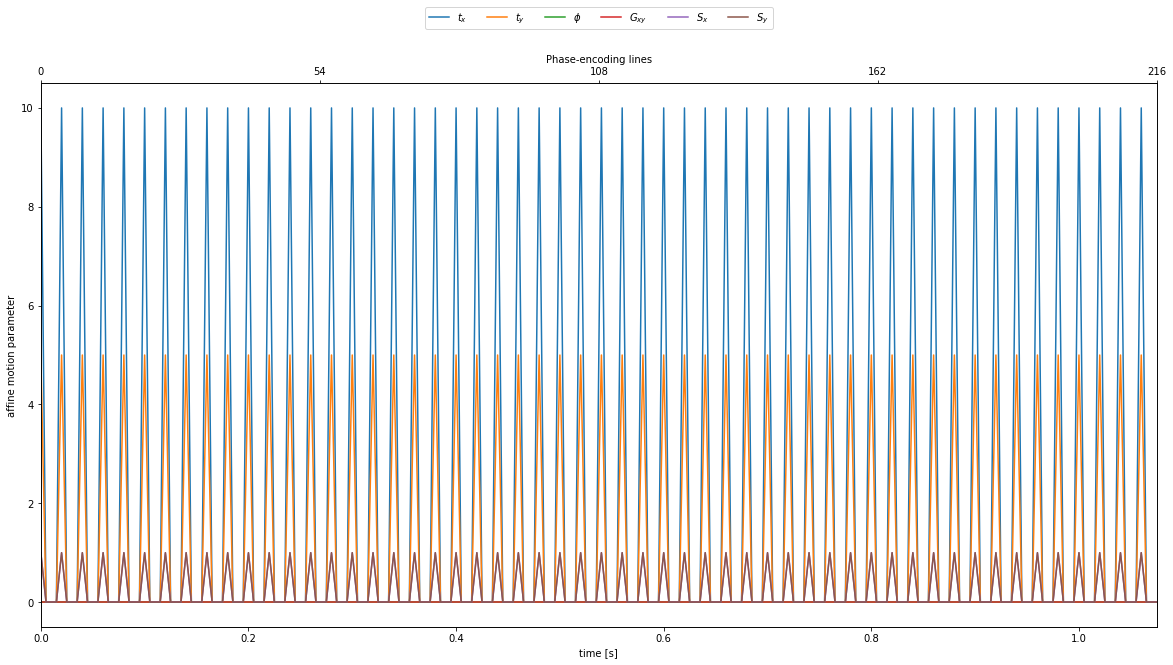

In [ ]:
p = [10, 5, 0, 0, 1, 1]
TR = 5E-3

# abrupt motion
motion_course = np.zeros((np.shape(mask_motion)[1], len(p)))
for idx, cp in enumerate(p):
  motion_course[:,idx] = np.squeeze(np.abs(mask_motion[0,:,0] * cp))

plot_motion_course(motion_course, TR)

**Task 7:** Create a periodic motion whose translational motion $t_x$ follows a sinus rhythm with frequency $\omega_x=5 \text{s}^{-1}$ , maximal amplitude 15, and $t_y$ follows a cosine rhythm with a frequency $\omega_y=6 \text{s}^{-1}$, maximal amplitude 8. Both motions happen at every 4-th phase-encoding line. Plot the affine motion parameters over time (TR=5 ms).

In [ ]:
mask_motion_curr = np.tile(np.squeeze(np.abs(mask_motion[0,:,0]))[:, np.newaxis], (1, 6))

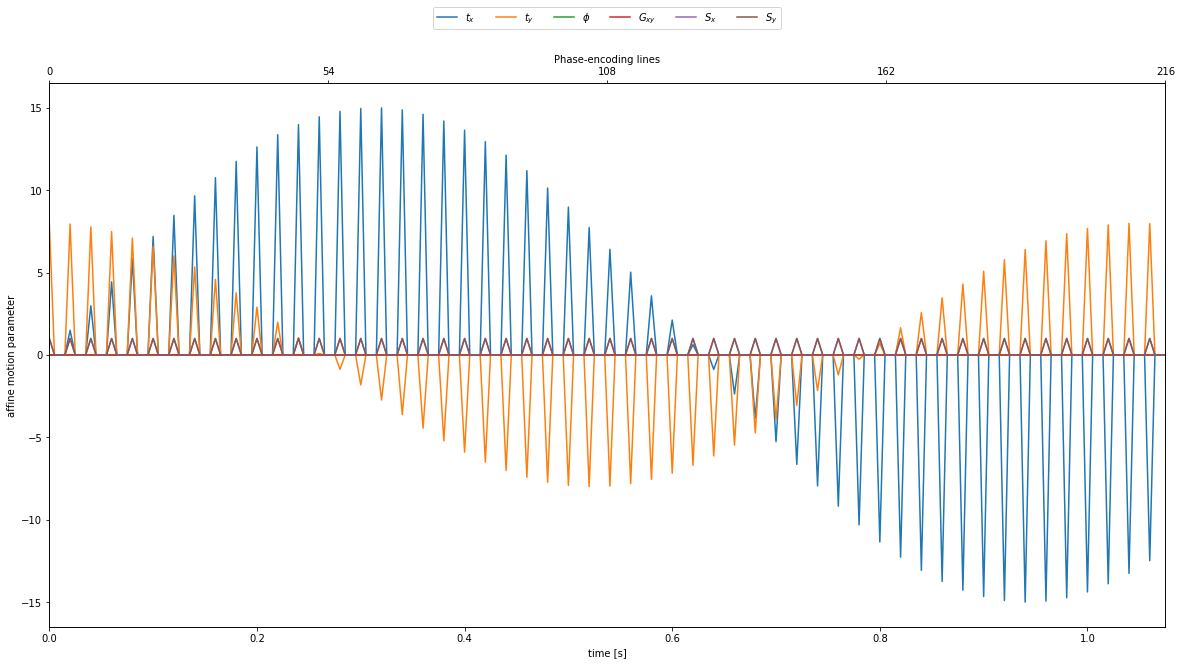

In [ ]:
p = [15, 8, 0, 0, 1, 1]
TR = 5E-3

# periodic motion
time = np.arange(np.shape(mask_motion)[1]) * TR
motion_signal = np.concatenate((np.stack([p[0] * np.sin(5 * time), p[1] * np.cos(6 * time)], axis=1), np.tile(p[2:], (len(time), 1))), axis=1)
motion_course = np.zeros((np.shape(mask_motion)[1], len(p)))
mask_motion_curr = np.tile(np.squeeze(np.abs(mask_motion[0,:,0]))[:, np.newaxis], (1, len(p)))  # when is motion happening over time for each motion parameter
for idx, cp in enumerate(p):
  motion_course[:,idx] = mask_motion_curr[:, idx] * motion_signal[:,idx]

plot_motion_course(motion_course, TR)

**Task 8:** Corrupt the k-space now with the time-dependent motion parameters from Task 7 and visualize the motion-affected image.

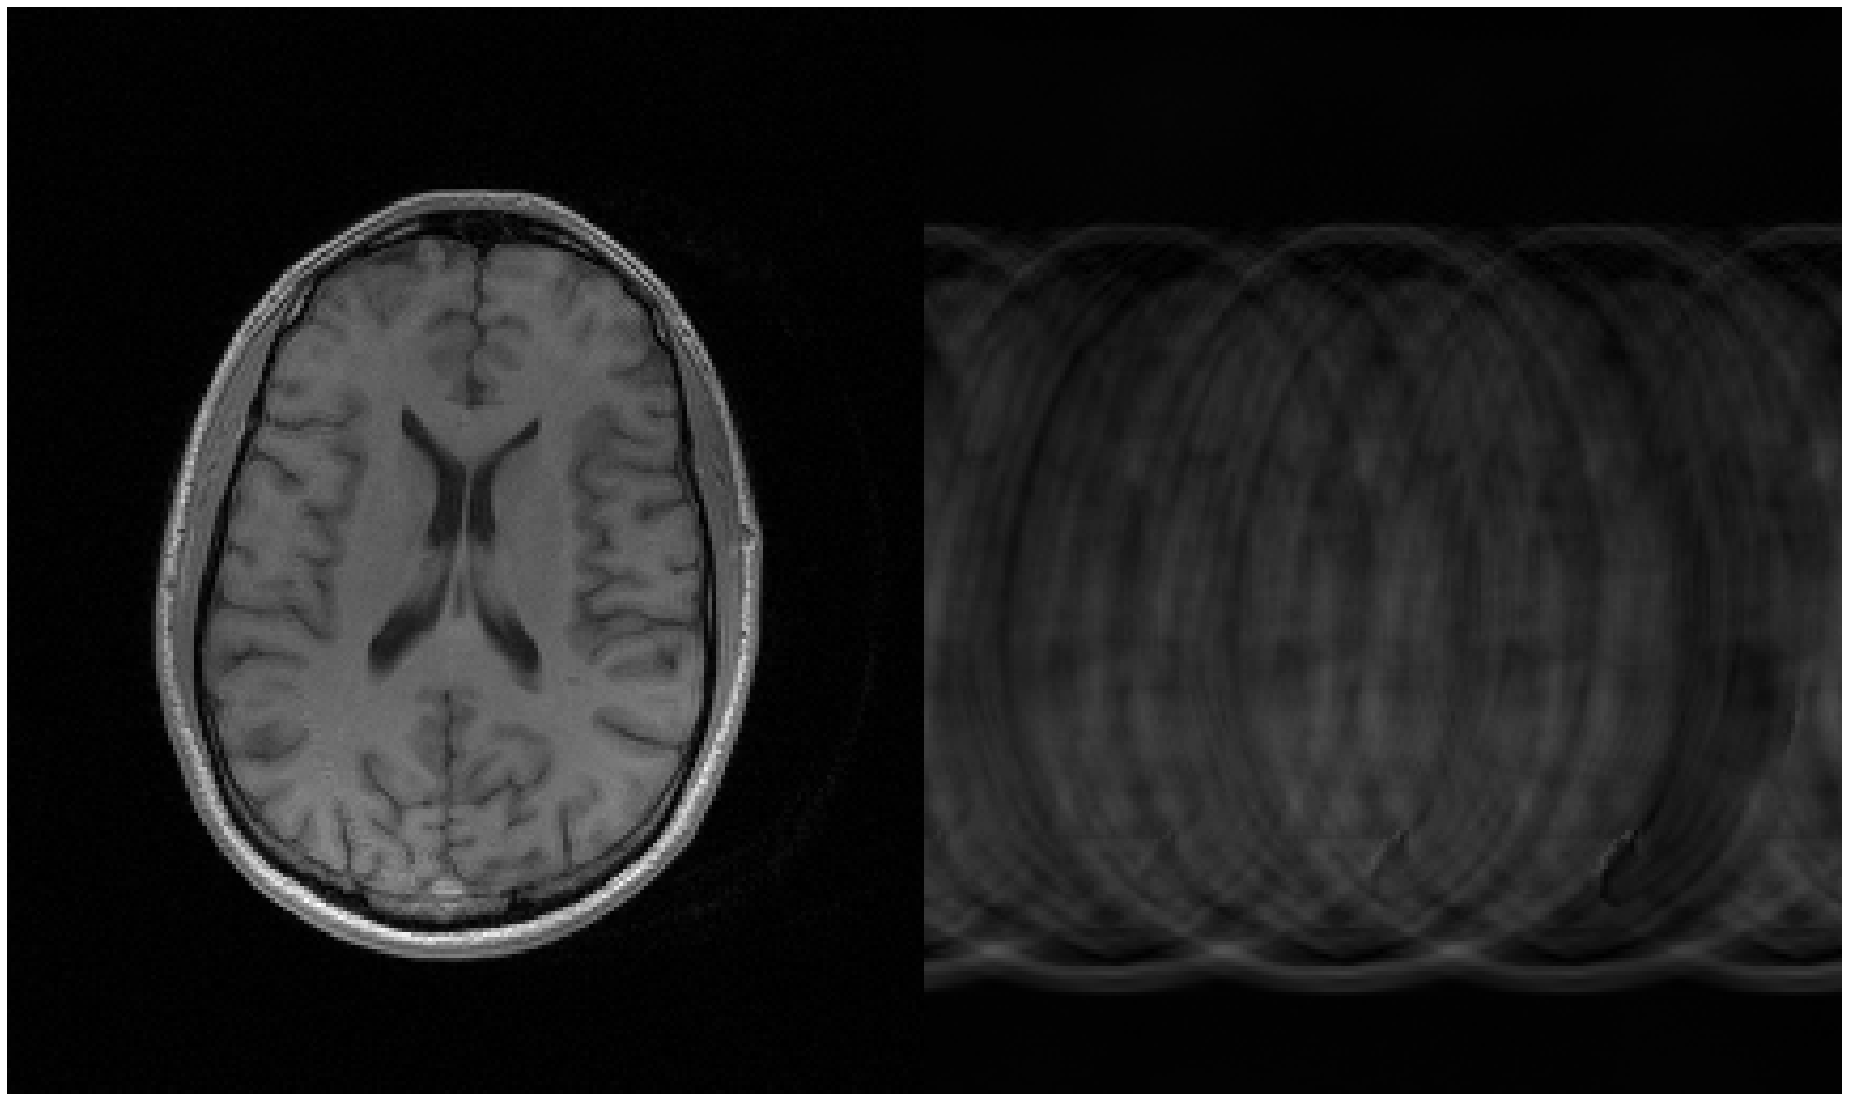

In [ ]:
kspace_motion, mask_motion = simulate_motion(img_cc, smaps, sampling_mask_fs, motion_course)
img_motion = mriAdjointOp(kspace_motion, smaps, sampling_mask_fs)

plot(np.stack([img_cc, img_motion], -1))

It is also conceivable that different motion parameters are happening at different time points, i.e. we will have a different `mask_motion` for each motion parameter.

**Task 9:** Create a periodic motion whose translational motion $t_x$ follows a sinus rhythm with frequency $\omega_x=5 \text{s}^{-1}$ , maximal amplitude 15, and $t_y$ follows a cosine rhythm with a frequency $\omega_y=6 \text{s}^{-1}$, maximal amplitude 8. Translation $t_x$ happens every 4-th phase-encoding line, whereas translation $t_y$ happens at every 8-th phase-encoding line. Plot the affine motion parameters over time (TR=5 ms).

In [ ]:
p = [15, 8, 0, 0, 1, 1]
TR = 5E-3

# periodic motion
time = np.arange(np.shape(mask_motion)[1]) * TR
motion_signal = np.concatenate((np.stack([p[0] * np.sin(5 * time), p[1] * np.cos(6 * time)], axis=1), np.tile(p[2:], (len(time), 1))), axis=1)
motion_course = np.zeros((np.shape(mask_motion)[1], len(p)))
mask_motion_curr = np.tile(np.squeeze(np.abs(mask_motion[0,:,0]))[:, np.newaxis], (1, len(p)))  # when is motion happening over time for each motion parameter
for idx, cp in enumerate(p):
  motion_course[:,idx] = mask_motion_curr[:, idx] * motion_signal[:,idx]

plot_motion_course(motion_course, TR)

### Motion in undersampled/accelerated imaging
**Task 5:** Perform a Cartesian undersampling (regular and random) using the provided function `generate_mask()`.


In [ ]:
def generate_mask(R, nPE, nFE, nRef=20, mode='regular'):
  # R     desired acceleration factor
  # nPE   amount of phase-encoding lines
  # nFE   amount of frequency-encoding lines
  # nRef  amount of fully-sampled center lines
  # mode  'regular': Parallel-Imaging-like/regular undersampling, 'random': Compressed-Sensing-like/random undersampling
  if mode == 'random':
    mask = np.random.choice([1, 0],(nPE),p=[1/R, 1-1/R])
    mask[nPE//2-nRef//2:nPE//2+nRef//2] = 1
  elif mode == 'regular':
    mask = np.zeros(nPE)
    mask[::R] = 1
    mask[nPE//2-nRef//2:nPE//2+nRef//2] = 1
  else:
    raise ValueError(f'Mode {mode} not defined')

  Reff = nPE/np.sum(mask)
  print(f'Reff={Reff}')

  mask = mask.reshape(1, nPE).repeat(nFE, axis=0)

  return mask[:,:,np.newaxis]

Now, generate the mask and visualize it (we visualize only a fraction in frequency encoding direction).



Reff=2.541176470588235


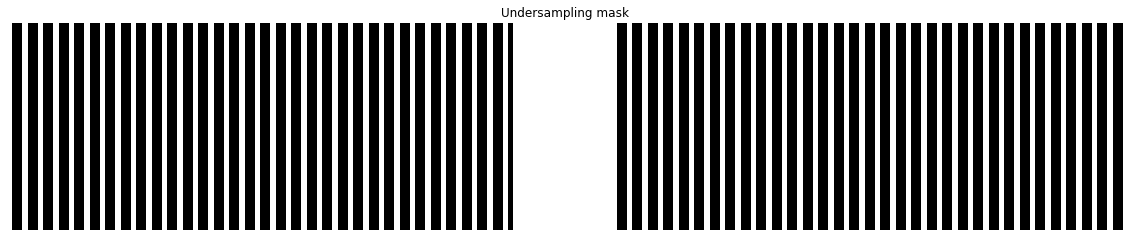

In [ ]:
np.random.seed(1001)
sampling_mask = generate_mask(R=3, nPE=np.shape(img_cc)[1], nFE=np.shape(img_cc)[0], mode='regular')

medutils.visualization.imshow(sampling_mask[:40,:,0], 'Undersampling mask', figsize=(20,20))

Next you can examine the impact of the undersampling masks on the reconstructed image

**Task 5:** Examine the impact of undersampling on the image.

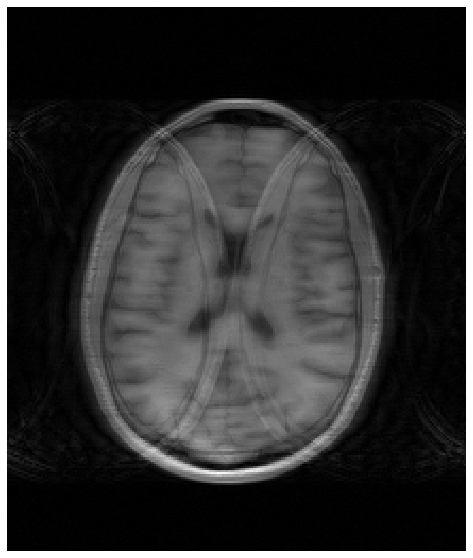

In [ ]:
img_cc_us = mriAdjointOp(kspace, smaps, sampling_mask)
plot(img_cc_us)

Let us now combine accelerated imaging with the impact of motion.

**Task X:** Induce motion in the undersampled data, assuming every 4-th phase-encoding line is affected

## Motion in radial imaging
Let's examine the impact of motion in radial imaging. We will therefore first need to radially sample the data. For reconstruction, we use the [gpuNUFFT](https://github.com/andyschwarzl/gpuNUFFT) package with the Python interface provided by [pySAP-mri](https://github.com/CEA-COSMIC/pysap-mri/). Alternatively, one could also use the [BART](https://mrirecon.github.io/bart/) toolbox.

In [50]:
# getting the image into quadrativ FOV
#img_qfov = np.pad(img, ((0,), (int(np.abs(nX-nY)/2),), (0,)))
nRead = np.amax(np.shape(img)[0:2])
img_qfov = zpad(img, (nRead, nRead, np.shape(img)[2])).astype(np.complex64)
img_qfov = img_qfov[:,:,np.newaxis,:]
kspace_qfov = fft2c(img_qfov)

import espirit
smaps_rad_espirit = espirit.espirit(kspace_qfov, 8, 20, 0.05, 0)

smaps_rad = smaps_rad_espirit[:,:,0,:,0]

Option A) gpuNUFFT

/usr/local/lib/python3.7/dist-packages/mri/operators/fourier/utils/processing.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


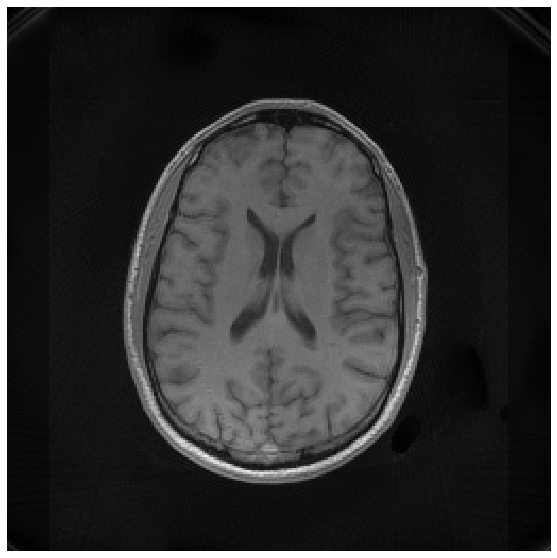

In [80]:
from mri.operators.utils import convert_locations_to_mask
from mri.operators import NonCartesianFFT

img_rad = rss(img_qfov[:,:,0,:])
acc = 1
nSlices = 1

nyquist_spokes = np.round(np.pi / 2 * nRead)

if acc > 1:
    n_spokes = int(np.round(nyquist_spokes / acc))
else:
    n_spokes = int(nyquist_spokes)
startangle = 0
kpos = get_kpos(nRead, n_spokes, 'golden', startangle)
dcf = compute_radial_dcf(kpos)
dcf = dcf * nRead * np.pi

kpos = np.tile(kpos.reshape(1, -1, nRead * n_spokes), (nSlices, 1, 1))
dcf = np.tile(dcf.reshape(1, 1, nRead * n_spokes) / np.max(dcf), (nSlices, 1, 1))

kpos = np.transpose(kpos[0, ...], (1, 0))
mask_rad = convert_locations_to_mask(kpos, (nRead, nRead))
dcf = np.transpose(dcf[0, ...], (1, 0))
csm = np.transpose(smaps_rad, (2, 0, 1))

# NUFFT operator
nufft = NonCartesianFFT(samples=kpos, shape=[nRead, nRead], n_coils=np.shape(csm)[0], density_comp=dcf, smaps=csm, implementation='gpuNUFFT')
kspace_radial = nufft.op(img_rad)
img_radial = nufft.adj_op(kspace_radial)
plot(img_radial)

In [81]:
# iterative SENSE
import numpy as np
import tensorflow as tf
from merlintf.keras.layers.data_consistency import itSENSE
from merlintf.keras.layers.mri import MulticoilForwardOp, MulticoilAdjointOp

def iterativeSENSE(kspace, smap=None, mask=None, noisy=None, 
            fwdop=MulticoilForwardOp, adjop=MulticoilAdjointOp,
            add_batch_dim=True, channel_dim_defined=True, max_iter=10, tol=1e-12, weight_init=1.0, weight_scale=1.0):
    # kspace        raw k-space data as [batch, coils, X, Y] or [batch, coils, X, Y, Z] or [batch, coils, time, X, Y] or [batch, coils, time, X, Y, Z]
    # smap          coil sensitivity maps with same shape as kspace (or singleton dimension for time)
    # mask          subsampling including/excluding soft-weights with same shape as kspace
    # noisy         initialiaztion for reconstructed image, if None it is created from A^H(kspace)
    # max_iter      maximum number of iterations for CG/iterative SENSE
    # tol           tolerance for stopping condition for CG/iterative SENSE
    # weight_init   initial weighting for lambda regularization parameter
    # weight_scale  scaling factor for lambda regularization parameter

    if add_batch_dim:
      kspace = kspace[np.newaxis, ...]
      smap = smap[np.newaxis, ...]
      mask = mask[np.newaxis, ...]
      noisy = noisy[np.newaxis, ...]
    
    # Forward and Adjoint operators
    A = fwdop
    AH = adjop

    if smap is None:
      if noisy is None:
          noisy = AH(kspace)

      if mask is None:
        mask = get_kpos(np.shape(noisy)[1], np.round(np.pi / 2 * np.shape(noisy)[1]), 'golden', 0.0)
      
    else:
      if mask is None:
          mask = tf.ones(np.shape(kspace), dtype=tf.float32)

      if noisy is None:
          noisy = AH(kspace, mask, smap)[..., 0]

    model = itSENSE(A, AH, weight_init=weight_init, weight_scale=weight_scale, max_iter=max_iter, tol=tol)
    if smap is None:  # non-Cartesian (smaps and mask embedded in NUFFT operator)
      return model([noisy, kspace])
    else:  # Cartesian
      return model([noisy, kspace, mask, smap])

# Cartesian
A = MulticoilForwardOp(center=True, coil_axis=1, channel_dim_defined=True)
AH = MulticoilAdjointOp(center=True, coil_axis=1, channel_dim_defined=True)
img_recon = iterativeSENSE(np.transpose(kspace, (2, 0, 1)), np.transpose(smaps, (2, 0, 1)), fwdop=A, adjop=AH)

# non-Cartesian
img_recon_rad = iterativeSENSE(kspace_radial, fwdop=nufft.op, adjop=nufft.adj_op)

padconv layers in keras.layers.convolutional could not be loaded. Optox might not be installed.


ModuleNotFoundError: ignored

Option B) BART

In [ ]:
import cfl
cfl.writecfl('imgrad', img_rad)

In [ ]:
%%bash
SAMPLES=256
SPOKES=402  # pi/2 * SAMPLES
bart traj -x$SAMPLES -y$SPOKES -r tmp_traj
bart scale 0.5 tmp_traj traj
bart nufft traj imgrad kspace_rad
bart show -m kspace_rad
bart nufft -a traj kspace_rad imgreco

In [ ]:
plotcfl(['imgreco'])
imgreco = cfl.readcfl('imgreco')

In [ ]:
plotcfl(['kspace_rad'])
kspace_rad = cfl.readcfl('kspace_rad')

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Range', max=1.0), IntSlider(value=0, des…

### Motion in undersampled/accelerated imaging

# Motion estimation / image registration

In this part of the tutorial we will have a closer look at image registration using conventional and deep learning-based solutions. We will only focus on pairwise registrations, i.e. registering a moving image $\rho_m(x)$ to a fixed image $\rho_f(x)$. The fixed and moving image are of dimension $N$ and are each defined on their own spatial domain: $\Omega_f \subset \mathbb{R}^N$ and $\Omega_m \subset \mathbb{R}^N$. The task of registration is to find a displacement $u(x)$ that makes $\rho_m(x+u(x))$ spatially aligned to $\rho_f(x)$. Equivalently we can say that registration is the process to find the transformation/displacement $T(x) = x+u(x)$ that makes $\rho_m(T(x))$ spatially aligned to $\rho_f(x)$. The transformation is defined as a mapping from the fixed image to the moving image, i.e. $T: \Omega_f \subset \mathbb{R}^N \to \Omega_m \subset \mathbb{R}^N$. The flow/displacement/motion field $u(x)$ contains the flows in the respective directions $u(x) = [u_x(x), u_y(x), \dots]$.

This transformation $T$, respectively its flow/displacement/motion field $u$ is also known as the *forward* motion $u^{(F)}$ (for simplicity we will refer to the forward motion field as $u$). Consequently, we also have a *backward* motion $u^{(B)}$. Ideally, the forward and backward motion should be isomorph, i.e. $u(u^{(B)}(x)) = x$ which allows to obtain either of the flows from the other one. For some cases, it might also be beneficial if the flows are diffeomorph, i.e. forward and backward motion are continously differentiable. During optimization, we are actually solving for the backward motion and later invert this flow to obtain the forward motion. This is usally more numerically stable as we expect that there is a matching voxel in the fixed image to which we can morph the moving image's voxel.   

The main properties of a registration algorithm are:
- dimensionality: 2D to 2D, 2D to 3D, 3D to 3D, ...
- spatial motion: rigid, affine, elastic (non-rigid)
- input modality: mono-modal, multi-modal
- similarity measure: landmark-based, image-intensity based
- algorithm: optical flow, diffusion-based, splines (B-splines, thin-plate splines, ...), deep learning, ...

## Conventional image registration
For the conventional image registration methods, we will have a look at the differences between optical flow and B-Spline based registrations, as these methods are the most commonly used ones. Moreover, deep learning-based registrations are often motivated or based on optical flow methods. 

### Optical Flow
We will first examine an optical flow-based image registration. Therefore we create a pair of motion-free and motion-affected image.

In [ ]:
img_fixed = rss(img)
img_moving = transform_img(img_fixed, [4, 8, 10, 0.05, 1, 1])
plot(np.stack([img_fixed, img_moving], -1))

**Task XXX:** Let us define the optical flow registration using the scikit-image (or any other library of your liking) for the Lucas-Kanade algorithm. Plot the obtained deformation field as quiver and color-plots using `plot` and `flow_to_color`, respectively.

*Hint:* Check the orientation of the flow for the $x$ and $y$ component, i.e. verify the displacement for a translational motion (`[4, 0, 0, 0, 0, 0]`) in $x$ direction first.

In [ ]:
from skimage.registration import optical_flow_ilk
uy, ux = optical_flow_ilk(img_fixed, img_moving)

For displaying the flow fields, we can show them as a quiver plot (vector field overlaid to image) or as a color-encoded image (color depicts flow angle and hue depicts magnitude).

In [ ]:
flows = np.stack([ux, uy], -1)

# quiver plots
plot(np.stack([img_fixed, img_moving], -1), np.stack[np.zeros_like(flows), flows], -1)

# color-wheel plot
plot_flow(flows)

**Task XXX:** Inspect and display the deformed/warped image using `warp_2D()`.

In [ ]:
img_warped = warp_2D(img_moving, np.stack([ux, uy], -1))
plot(np.stack([img_fixed, img_moving, img_warped], -1))

**Task XXX:** Perform the registration using the Total-variation L1-regularized optical flow algorithm.

In [ ]:
from skimage.registration import optical_flow_tvl1
uy, ux = optical_flow_tvl1(img_fixed, img_moving)

**Task XXX:** Evaluate the obtained registration performance in the warped image. Compute the photometric loss = $\sum (\rho_\text{warped} - \rho_f)^2$, structural similarity (SSIM) and peak signal to noise ratio (PSNR). 

In [ ]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

photo = mean_squared_error(img_fixed, img_warped)
ssim = structural_similarity(img_fixed, img_warped)
psnr = peak_signal_noise_ratio(img_fixed, img_warped)

print('Photometric: ' % photo)
print('SSIM: ' % ssim)
print('PSNR: ' % psnr)

**Task XXX:** Now we evaluate the performance of the registration on the obtained motion/displacement field. Calculate 
- the determinant of the Jacobian of the transformation <br/>
$\text{Jac} = \operatorname{det}(\nabla T(x)) = \left| \begin{bmatrix} \frac{\partial u_x}{\partial x} + 1 & \frac{\partial u_x}{\partial y} \\ \frac{\partial u_y}{\partial x} & \frac{\partial u_y}{\partial y} + 1 \end{bmatrix} \right|$
- the divergence of the displacement field <br/>
$\operatorname{div}(u) = \nabla \cdot u = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}$
- absolute displacement field change in selected direction $p=\lbrace x,y \rbrace$ <br/>
$| \nabla u | = \sqrt{ \left(\frac{\partial u_x}{\partial p}\right)^2 + \left(\frac{\partial u_y}{\partial p}\right)^2}$



*Hint:* You may either implement these functions yourself or use functions provided by [SimpleITK](https://itk.org/Doxygen/html/classitk_1_1DisplacementFieldJacobianDeterminantFilter.html). 

In [ ]:
flows = np.stack([ux, uy], -1)

sitk_displacement_field = sitk.GetImageFromArray(flows, isVector=True)
jacobian_det_volume = sitk.DisplacementFieldJacobianDeterminant(sitk_displacement_field)
jacobian_det_np_arr = sitk.GetArrayViewFromImage(jacobian_det_volume)

# metrics
jac = np.linalg.det(jacobian_det_np_arr)
div = np.trace(jacobian_det_np_arr - np.eye(2))
absdisp_x = np.sum(np.power((jacobian_det_np_arr - np.eye(2))[:,0], 2))
absdisp_y = np.sum(np.power((jacobian_det_np_arr - np.eye(2))[:,1], 2))


**Task XXX:** Invert the flow fields by changing the registration direction (i.e. swapping moving and fixed image) and compare against direct inversion.

In [ ]:
# redo registration
uBy, uBx = optical_flow_ilk(img_moving, img_fixed)
img_warped_B = warp_2D(img_fixed, np.stack([uBx, uBy], -1))

# direct inversion
uBx_direct = -uBx
uBy_direct = -uBy
img_warped_B_direct = warp_2D(img_fixed, np.stack([uBx_direct, uBy_direct], -1))

# plot the results
plot(np.stack([img_warped, img_warped_B, img_warped_B_direct], -1), title='Warped: mov->fix, fix->mov (inverted reg.), fix->mov (direct inv.)')

# plot the flow fields
plot_flow(np.stack([uBx, uBy], -1), 'inverted registration')
plot_flow(np.stack([uBx_direct, uBy_direct], -1), 'direct inversion')

**Task XXX:** Check if the flows are isomorph.

In [ ]:
isox = uBx + ux
isoy = uBy + uy

isox_direct = uBx_direct + uBx
isoy_direct = uBy_direct + uBy

# plot the flow fields
plot_flow(np.stack([isox, isoy], -1), 'Isomorphism: inverted registration')
plot_flow(np.stack([isox_direct, isoy_direct], -1), 'Isomorphism: direct inversion')

### B-Spline

In [ ]:
sitk.TransformToDisplacementField(bspline_transform, 
                                  sitk.sitkVectorFloat64,
                                  fixed_image.GetSize(),
                                  fixed_image.GetOrigin(),
                                  fixed_image.GetSpacing(),
                                  fixed_image.GetDirection())

## Deep learning-based image registration

# Motion-compensated image reconstruction